In [1]:
import os
import sys
if os.getenv("ORCA_PATH"):
    ORCA_PATH = os.getenv("ORCA_PATH")
else:
    # change this to the right path if you use a different path
    # or specify the ORCA_PATH environmental variable
    ORCA_PATH = "../orca"
sys.path.append(ORCA_PATH)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from IPython.core.pylabtools import figsize


<PYTHONPATH>/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import orca_predict 
orca_predict.load_resources(models=['1M'],use_cuda=True)
from orca_predict import *

In [4]:
%load_ext rpy2.ipython

In [5]:
import glob
import numpy as np
import torch
motiffiles = sorted(glob.glob('./resources/JASPAR/*.jaspar'))

from Bio.motifs import jaspar
motifs=[]
for m in motiffiles:
    motifs.append(jaspar.read(open(m,'r'), 'jaspar').pop())
    
motifname = [m.name for m in motifs]
motifid = [m.matrix_id for m in motifs]
motifseq = {m.name: m.consensus for m in motifs}
motifpwm = {m.name: m.pwm for m in motifs}
motifkernels=[]
for i in range(len(motifname)):
    pmat = np.vstack([ motifpwm[motifname[i]][b] for b in ['A','C','G','T']]) 
    motifkernels.append( np.log2((pmat+ 0.01) / (np.array([0.295,0.205,0.205,0.295])[:,None]+ 0.01)))
motifkernelmat = np.zeros( (len(motifname), 25, 4))

for i in range(len(motifname)):
    k = motifkernels[i]
    starti = np.round((25 - k.shape[1])/2.0).astype(int)
    motifkernelmat[i, starti : starti+k.shape[1]]=k.T
motifkernelmat_cuda = torch.FloatTensor(motifkernelmat).cuda().permute(0,2,1)
motifkernelmat_rc_cuda = torch.FloatTensor(motifkernelmat[:,::-1,::-1].copy()).cuda().permute(0,2,1)

In [6]:
#read the output of the local interaction screen (for 10bp sequence disruptions)
#and do motif scanning
def read_local_interaction_output(file):
    a=pd.read_csv(file, sep='\t', header=None)
    a['N']=False
    motifmatches = []
    motifmatches10 = []
    for i in range(a.shape[0]):
        try:
            seq = hg38.get_sequence_from_coords(a.iloc[i,0],a.iloc[i,1]-200,a.iloc[i,2]+200)
            if not 'N' in seq:
                seq = hg38.get_encoding_from_coords(a.iloc[i,0],a.iloc[i,1]-200,a.iloc[i,2]+200)
                sequence = seq[None,:]
                origseqT = torch.FloatTensor(sequence.copy()).transpose(1,2).cuda()

                motifmatch = torch.nn.functional.conv1d(origseqT, motifkernelmat_cuda[:,:,:],padding=12).cpu().numpy().squeeze().max(axis=1)
                motifmatch_rc = torch.nn.functional.conv1d(origseqT, motifkernelmat_rc_cuda[:,:,:],padding=12).cpu().numpy().squeeze().max(axis=1)
                motifmatches.append(np.fmax(motifmatch,motifmatch_rc))
                
                seq = hg38.get_encoding_from_coords(a.iloc[i,0],a.iloc[i,1]-10,a.iloc[i,2]+10)
                sequence = seq[None,:]
                origseqT = torch.FloatTensor(sequence.copy()).transpose(1,2).cuda()

                motifmatch = torch.nn.functional.conv1d(origseqT, motifkernelmat_cuda[:,:,:],padding=12).cpu().numpy().squeeze().max(axis=1)
                motifmatch_rc = torch.nn.functional.conv1d(origseqT, motifkernelmat_rc_cuda[:,:,:],padding=12).cpu().numpy().squeeze().max(axis=1)
                motifmatches10.append(np.fmax(motifmatch,motifmatch_rc))
            else:
                a.loc[i, 'N']=True
        except AssertionError:
            a.loc[i,'N']=True
    return a, np.array(motifmatches), np.array(motifmatches10)

#output: dataframe with structural impact score-1Mb, motif match (200bp), motif match (10bp)
a, motifmatches, motifmatches_10 = read_local_interaction_output('./figure_data/local_interaction.h1esc_1m.0.01.bedgraph')
b, motifmatches_b,  motifmatches_b_10= read_local_interaction_output('./figure_data/local_interaction.hff_1m.0.01.bedgraph')
a_bg, motifmatches_bg, motifmatches_bg_10 = read_local_interaction_output('./figure_data/local_interaction.h1esc_1m.shuf100k.bedgraph')


In [7]:
b_bg=a_bg.copy()
b_bg[3]=pd.read_csv('./figure_data/local_interaction.hff_1m.shuf100k.bedgraph', sep='\t', header=None)[3]


In [8]:
torch.save({'a':a, 'motifmatches':motifmatches, 
            'motifmatches_10':motifmatches_10, 'b':b,
           'motifmatches_b':motifmatches_b, 'motifmatches_b_10':motifmatches_b_10,
           'a_bg':a_bg, 'motifmatches_bg':motifmatches_bg, 'motifmatches_bg_10':motifmatches_bg_10}, 
           './figure_data/local_interaction_motif.pth')

In [9]:
import pyBigWig
bw = pyBigWig.open(ORCA_PATH + "/extra/H1_CTCF_ENCFF473IZV.bigWig")
bw2 = pyBigWig.open(ORCA_PATH + "/extra/foreskin_fibroblast_CTCF_ENCFF761RHS.bigWig")
ctcfs = []
for i in range(a.shape[0]):
    if  a['N'][i]==False:
        ctcfs.append(bw.values(a.iloc[i,0], a.iloc[i,1]-100, a.iloc[i,2]+100,numpy=True).max())
ctcfs_b = []
for i in range(b.shape[0]):
    if  b['N'][i]==False:
        ctcfs_b.append(bw2.values(b.iloc[i,0], b.iloc[i,1]-100, b.iloc[i,2]+100,numpy=True).max())
        
ctcfs = np.array(ctcfs)
ctcfs_b = np.array(ctcfs_b)

In [10]:
import pyBigWig
bw = pyBigWig.open(ORCA_PATH + "/extra/H1_CTCF_ENCFF473IZV.bigWig")
bw2 = pyBigWig.open(ORCA_PATH + "/extra/foreskin_fibroblast_CTCF_ENCFF761RHS.bigWig")
ctcfs_bg = []
for i in range(a_bg.shape[0]):
    if  a_bg['N'][i]==False:
        ctcfs_bg.append(bw.values(a_bg.iloc[i,0], a_bg.iloc[i,1]-100, a_bg.iloc[i,2]+100,numpy=True).max())
ctcfs_b_bg = []
for i in range(a_bg.shape[0]):
    if  a_bg['N'][i]==False:
        ctcfs_b_bg.append(bw2.values(a_bg.iloc[i,0], a_bg.iloc[i,1]-100, a_bg.iloc[i,2]+100,numpy=True).max())
        
ctcfs_bg = np.array(ctcfs_bg)
ctcfs_b_bg = np.array(ctcfs_b_bg)

In [11]:
from scipy import stats

#t-test degree-of-freem helper functions adapted directly from scipy
def _equal_var_ttest_denom(v1, n1, v2, n2):
    df = n1 + n2 - 2.0
    svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
    denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2)) 
    return df, denom


def _unequal_var_ttest_denom(v1, n1, v2, n2):
    vn1 = v1 / n1
    vn2 = v2 / n2
    with np.errstate(divide='ignore', invalid='ignore'):
        df = (vn1 + vn2)**2 / (vn1**2 / (n1 - 1) + vn2**2 / (n2 - 1))

    df = np.where(np.isnan(df), 1, df)  
    denom = np.sqrt(vn1 + vn2)
    return df, denom


def ttest_ind_df(a, b, axis=0, equal_var=True, nan_policy='propagate'):
    v1 = np.var(a, axis, ddof=1)
    v2 = np.var(b, axis, ddof=1)
    n1 = a.shape[axis]
    n2 = b.shape[axis]

    if equal_var:
        df, denom = _equal_var_ttest_denom(v1, n1, v2, n2)
    else:
        df, denom = _unequal_var_ttest_denom(v1, n1, v2, n2)

    return df


In [12]:
#motif enrichment in structural impact sites (10bp sites with > 0.01 structural impact score -1Mb)
 
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.stats import fisher_exact
def fisher_t(x,y):
    px = np.sum(x)
    py = np.sum(y)
    return fisher_exact([[px,len(x)-px], [py,len(y)-py]])

#H1ESC

#consider non-CTCF sites and consider only one 10bp every 30bp to avoid motif scoring overlap (because 10bp flanking sequence is used in motif scoring)
test = motifmatches_10[(np.array(motifmatches)[:,98]< 6) &  (ctcfs<4)  & (a.loc[a['N']==False,3].values>0.01) & (a.loc[a['N']==False,1] % 30 == 0),:]
bg_inds = (a_bg.loc[a_bg['N']==False,1].values % 30 == 0)

a_enrich_p=[]
a_enrich_t=[]
a_enrich_tp=[]
a_enrich_tdf=[]
a_enrich_oddsratio=[]
a_enrich_fp=[]
for i in range(motifmatches_10.shape[1]):
    a_enrich_p.append(mannwhitneyu(test[:,i],
                motifmatches_bg_10[bg_inds,i], alternative='greater' )[1])
    a_enrich_t.append(ttest_ind(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False)[0])
    a_enrich_tp.append(ttest_ind(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False)[1])
    a_enrich_tdf.append(ttest_ind_df(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False))
    oddsratio, p = fisher_t(test[:,i]>12,
                motifmatches_bg_10[bg_inds,i]>12)
    a_enrich_oddsratio.append(oddsratio)
    a_enrich_fp.append(p)
a_enrich_p = np.array(a_enrich_p)
a_enrich_t = np.array(a_enrich_t)
a_enrich_tp = np.array(a_enrich_tp)
a_enrich_tdf = np.array(a_enrich_tdf)
a_enrich_oddsratio = np.array(a_enrich_oddsratio)
a_enrich_fp = np.array(a_enrich_fp)

#HFF

from scipy.stats import mannwhitneyu, ttest_ind
test = motifmatches_b_10[(np.array(motifmatches_b)[:,98]<6) * (ctcfs_b<4) * (b.loc[b['N']==False,3].values>0.01) *(b.loc[b['N']==False,1] % 30 == 0),:]
bg_inds = b_bg.loc[b_bg['N']==False,1].values % 30 == 0


b_enrich_p=[]
b_enrich_t=[]
b_enrich_tp=[]
b_enrich_tdf=[]
b_enrich_oddsratio=[]
b_enrich_fp=[]
for i in range(motifmatches_b_10.shape[1]):
    b_enrich_p.append(mannwhitneyu(test[:,i],
                motifmatches_bg_10[bg_inds,i], alternative='greater' )[1])
    b_enrich_t.append(ttest_ind(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False)[0])
    b_enrich_tp.append(ttest_ind(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False)[1])
    b_enrich_tdf.append(ttest_ind_df(test[:,i],
                motifmatches_bg_10[bg_inds,i], equal_var=False))
    oddsratio, p = fisher_t(test[:,i]>12,
                motifmatches_bg_10[bg_inds,i]>12)
    b_enrich_oddsratio.append(oddsratio)
    b_enrich_fp.append(p)
    
b_enrich_p = np.array(b_enrich_p)
b_enrich_t = np.array(b_enrich_t)
b_enrich_tp = np.array(b_enrich_tp)
b_enrich_tdf = np.array(b_enrich_tdf)
b_enrich_oddsratio = np.array(b_enrich_oddsratio)
b_enrich_fp = np.array(b_enrich_fp)

<PYTHONPATH>/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [13]:
%%R  -i a_enrich_t,a_enrich_tdf,b_enrich_t,b_enrich_tdf -o a_enrich_tz,b_enrich_tz
require('limma')
#t-statistics to z-scores
a_enrich_tz = zscoreT(a_enrich_t, a_enrich_tdf, method="hill")
b_enrich_tz = zscoreT(b_enrich_t, b_enrich_tdf, method="hill")

R[write to console]: Loading required package: limma



In [14]:
from statsmodels.stats.multitest import multipletests
_, b_enrich_tp_bh, _, _  = multipletests(b_enrich_tp, method='fdr_bh')
_, a_enrich_tp_bh, _, _  = multipletests(a_enrich_tp, method='fdr_bh')

In [15]:
#H1-ESC, t-test p-value
for i in np.argsort(-a_enrich_t):
    if(a_enrich_t[i]>0):
        print(motifname[i],a_enrich_t[i], a_enrich_tp[i])
    

Pou5f1::Sox2 60.40424953917913 0.0
POU5F1B 42.404876372828404 0.0
POU5F1 42.2218484063746 0.0
POU3F1 42.00107496908699 0.0
POU3F4 41.19216533288062 0.0
POU2F1 41.086224194787135 0.0
POU3F2 40.5427240892066 0.0
POU1F1 39.10682690218046 0.0
POU2F3 38.378536527217655 0.0
POU3F3 36.05223024505711 7.476771808807688e-281
POU2F2 35.68604181845004 2.769208951662532e-275
NFIL3 21.117224478167298 1.429281306753586e-98
SOX15 19.600607138677987 3.0940981065594034e-85
HLF 18.83540093999095 7.076036867702116e-79
SOX4 18.14329874910775 2.453478984558866e-73
SOX2 15.870319869904971 1.3828499182261786e-56
SOX8 15.33872150919659 5.5090028736697185e-53
TEAD3 14.916644909627355 3.2540932373057465e-50
SOX13 14.855080353348635 8.167367617477201e-50
NOTO 14.806628938375486 1.6584481920853624e-49
SOX9 14.60442934288812 3.27296962085763e-48
FOXB1 13.932633740724759 4.782957284487743e-44
SOX10 13.886474357681324 9.13919913896979e-44
ZIC4 13.811584550923891 2.576948928043955e-43
LIN54 13.635645704231447 2.887082

In [16]:
#H1-ESC, odds-ratio, fisher exact p-value
for i in np.argsort(-a_enrich_oddsratio):
    if a_enrich_fp[i] < 0.01:
        print(np.array(motifname)[i], a_enrich_oddsratio[i], a_enrich_fp[i])
    

Pou5f1::Sox2 48.70690973498189 0.0
POU5F1B 17.071606632081192 2.0964729102877074e-133
POU5F1 14.820376249051504 4.5836281684767907e-262
POU3F1 14.318621305717054 1.216902268670513e-214
POU3F2 13.782526337115073 2.9758385550489695e-234
POU2F1 13.285568012970575 1.293166913809328e-185
POU3F4 13.191273731714908 3.6417743181116747e-165
POU1F1 12.195829650648928 7.035731067622469e-181
NOTO 11.743928153065209 0.003322959591968541
POU2F3 11.465450958521304 9.302342337330422e-244
POU2F2 10.05272647809403 3.203657901173571e-226
POU3F3 9.578974382785097 6.598945290619166e-149
EMX2 6.200048828125 0.00017564409152997015
HLF 4.987598457062998 1.0261780560703454e-24
Sox17 4.453502334889927 6.641052106789589e-20
TEAD2 4.242850451620458 8.906997613476424e-39
E2F4 4.105069124423963 7.626054552701437e-07
ZIC3 3.9582921856989453 1.515426492628475e-32
SOX13 3.841261098215105 3.3549444870531326e-25
TEAD4 3.8185239686987416 2.315776222529196e-33
SOX8 3.7880438483012187 2.4720619912551764e-14
ZIC5 3.78119627

In [17]:
#HFF, t-test p-value
for i in np.argsort(-b_enrich_t):
    if(b_enrich_t[i]>0):
        print(motifname[i],b_enrich_t[i], b_enrich_tp[i])
    

FOSL1::JUND 174.04613296286516 0.0
FOSL1::JUNB 173.30271307754023 0.0
FOSL1::JUN 173.15316019339974 0.0
FOSL2::JUN 172.7911626767048 0.0
FOSB::JUNB 171.78372864270364 0.0
FOS::JUN 171.72663754560523 0.0
FOSL2::JUNB 171.65795871986995 0.0
Smad2::Smad3 171.49633831397998 0.0
FOS::JUNB 171.4460647270145 0.0
FOSL2::JUND 171.3780390108819 0.0
FOS::JUND 170.7990435495734 0.0
FOSL1 169.43677190540217 0.0
JUNB 169.26579823840274 0.0
BATF 168.7207974544986 0.0
JUN::JUNB 168.64475377517095 0.0
BATF::JUN 168.1249750936054 0.0
JUND 167.9900361976697 0.0
FOS 167.05780059322748 0.0
BATF3 166.38646148515704 0.0
JUN(var.2) 163.77282259946426 0.0
FOSL2 160.61936594656189 0.0
JDP2 156.56699639032368 0.0
BACH1 147.08555211892232 0.0
NFE2 145.8889367845162 0.0
BACH2 143.3020580497722 0.0
NFE2L1 137.44850640585986 0.0
MAFK 131.90856148950607 0.0
MAF::NFE2 122.7454643515036 0.0
Nfe2l2 120.10193163446255 0.0
Bach1::Mafk 114.31631331169838 0.0
FOSL1::JUND(var.2) 111.86743973871847 0.0
Atf1 81.37222039010457 0

ZNF16 14.359715220993143 1.0844128936192196e-46
HOXB9 14.29085046144208 2.894270189447073e-46
MYOD1 14.274844175520784 3.665000041322108e-46
TCF3 14.249005940112793 5.342073217225092e-46
TCF12(var.2) 14.248351372922933 5.3978061305875085e-46
RORA(var.2) 14.243759214400777 5.691126259898028e-46
LHX9 14.232410243951955 6.715294608313567e-46
HES7 14.040182488229942 1.0275352315912932e-44
GMEB2 14.021926453690929 1.322697220490882e-44
TBX5 13.963477654147486 3.0158288932520717e-44
FIGLA 13.927555035671263 4.953501301124173e-44
CLOCK 13.845234391653749 1.5523791221381716e-43
RARB(var.3) 13.795425782268886 3.105396741492158e-43
Alx1 13.632961582681608 2.903656220378249e-42
ZNF528 13.623382177364036 3.292005004835536e-42
RARA::RXRG 13.564447897002236 7.411279336150328e-42
ZIC1 13.204712399920275 9.284905916349178e-40
BHLHE22 13.058651226864567 6.264613778208151e-39
IKZF1 13.022013105439225 1.0127810526194591e-38
Tcf21 12.940920173968248 2.9089109867525205e-38
LBX2 12.856775116851285 8.7426387

In [18]:
#HFF, odds-ratio, fisher exact p-value
for i in np.argsort(-b_enrich_oddsratio):
    if  b_enrich_fp[i] < 0.01:
        print(np.array(motifname)[i], b_enrich_oddsratio[i], b_enrich_fp[i])
    

FOSL1::JUND 166.8396429511768 0.0
JUNB 148.65639469837822 0.0
JUN::JUNB 143.3200208183776 0.0
FOSL1 141.38969995922164 0.0
JUND 138.49735302960966 0.0
FOSL2::JUN 133.5784050828254 0.0
JDP2 130.6300506636981 0.0
FOSL2 123.92064107422816 0.0
FOS::JUND 122.87355249611825 0.0
FOS 120.53350221289388 0.0
FOS::JUNB 120.46123530910059 0.0
FOSL1::JUN 120.36116682387429 0.0
FOSL2::JUND 120.17197420431194 0.0
FOS::JUN 120.12363397146477 0.0
FOSL2::JUNB 119.30806398884118 0.0
FOSL1::JUNB 117.32872524684926 0.0
FOSB::JUNB 116.581627558662 0.0
JUN(var.2) 114.71088044537528 0.0
Smad2::Smad3 112.06773982093587 0.0
BATF 111.22197010144154 0.0
BATF3 110.53274324665139 0.0
BATF::JUN 106.4812115807113 0.0
NFE2 80.32550526803355 0.0
BACH2 70.66112594580514 0.0
BACH1 38.90420150757045 0.0
NFE2L1 37.64530816640986 0.0
MAF::NFE2 31.183534814712182 0.0
Bach1::Mafk 28.431443450451372 0.0
Nfe2l2 24.80015535392599 0.0
MAFK 12.61055255079023 0.0
CEBPB 11.487762584144003 4.3873574426258296e-30
CEBPE 10.788855191226

In [19]:
df = pd.DataFrame({'motif': motifname,'motif id':motifid, 't-statistic':a_enrich_t,
              'p-value':a_enrich_tp,'BH FDR':a_enrich_tp_bh,
            'odds ratio (log odds > 12)':a_enrich_oddsratio })
df = df.iloc[np.argsort(-df['t-statistic'])]

df.to_csv('./figure_data/local_interaction.nonCTCF.h1esc.csv')

In [20]:
df = pd.DataFrame({'motif': motifname,'motif id':motifid, 't-statistic':b_enrich_t,
              'p-value':b_enrich_tp,'BH FDR':b_enrich_tp_bh,
            'odds ratio (log odds > 12)':b_enrich_oddsratio })
df = df.iloc[np.argsort(-df['t-statistic'])]
df.to_csv('./figure_data/local_interaction.nonCTCF.hff.csv')

In [21]:
a.loc[a['N']==False,:].iloc[np.argwhere((np.array(motifmatches)[:,98]< 6) &  (ctcfs<4)  & (a.loc[a['N']==False,3].values>0.01))[:,0],:].iloc[:,:4].to_csv('./figure_data/local_interaction.h1esc_1m.0.01.noctcf.bedgraph', sep='\t',header=None,index=False)
b.loc[b['N']==False,:].iloc[np.argwhere((np.array(motifmatches_b)[:,98]<6) * (ctcfs_b<4) * (b.loc[b['N']==False,3].values>0.01))[:,0],:].iloc[:,:4].to_csv('./figure_data/local_interaction.hff_1m.0.01.noctcf.bedgraph', sep='\t',header=None,index=False)


In [22]:
%%R 
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [23]:
np.random.seed(0)
plotdata = pd.DataFrame(dict(motif=np.array(motifmatches)[:,98],motif10=np.array(motifmatches_10)[:,98], ctcf=ctcfs, score=a.loc[a['N']==False,3].values))
plotdata_b = pd.DataFrame(dict(motif=np.array(motifmatches_b)[:,98],motif10=np.array(motifmatches_b_10)[:,98], ctcf=ctcfs_b, score=b.loc[b['N']==False,3].values))
plotdata2 = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,98],motif10=np.array(motifmatches_bg_10)[:,98], ctcf=ctcfs_bg, score=a_bg.loc[a_bg['N']==False,3].values))
plotdata2 = plotdata2.iloc[np.random.permutation(plotdata2.shape[0])[:plotdata.shape[0]],:]
np.random.seed(0)
plotdata2_b = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,98],motif10=np.array(motifmatches_bg_10)[:,98], ctcf=ctcfs_b_bg, score=b_bg.loc[b_bg['N']==False,3].values))
plotdata2_b = plotdata2_b.iloc[np.random.permutation(plotdata2_b.shape[0])[:plotdata_b.shape[0]],:]

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggridges

R[write to console]: Loading required package: patchwork

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.12.2 using 36 threads (see ?getDTthreads).  Latest news: r-datatable.com



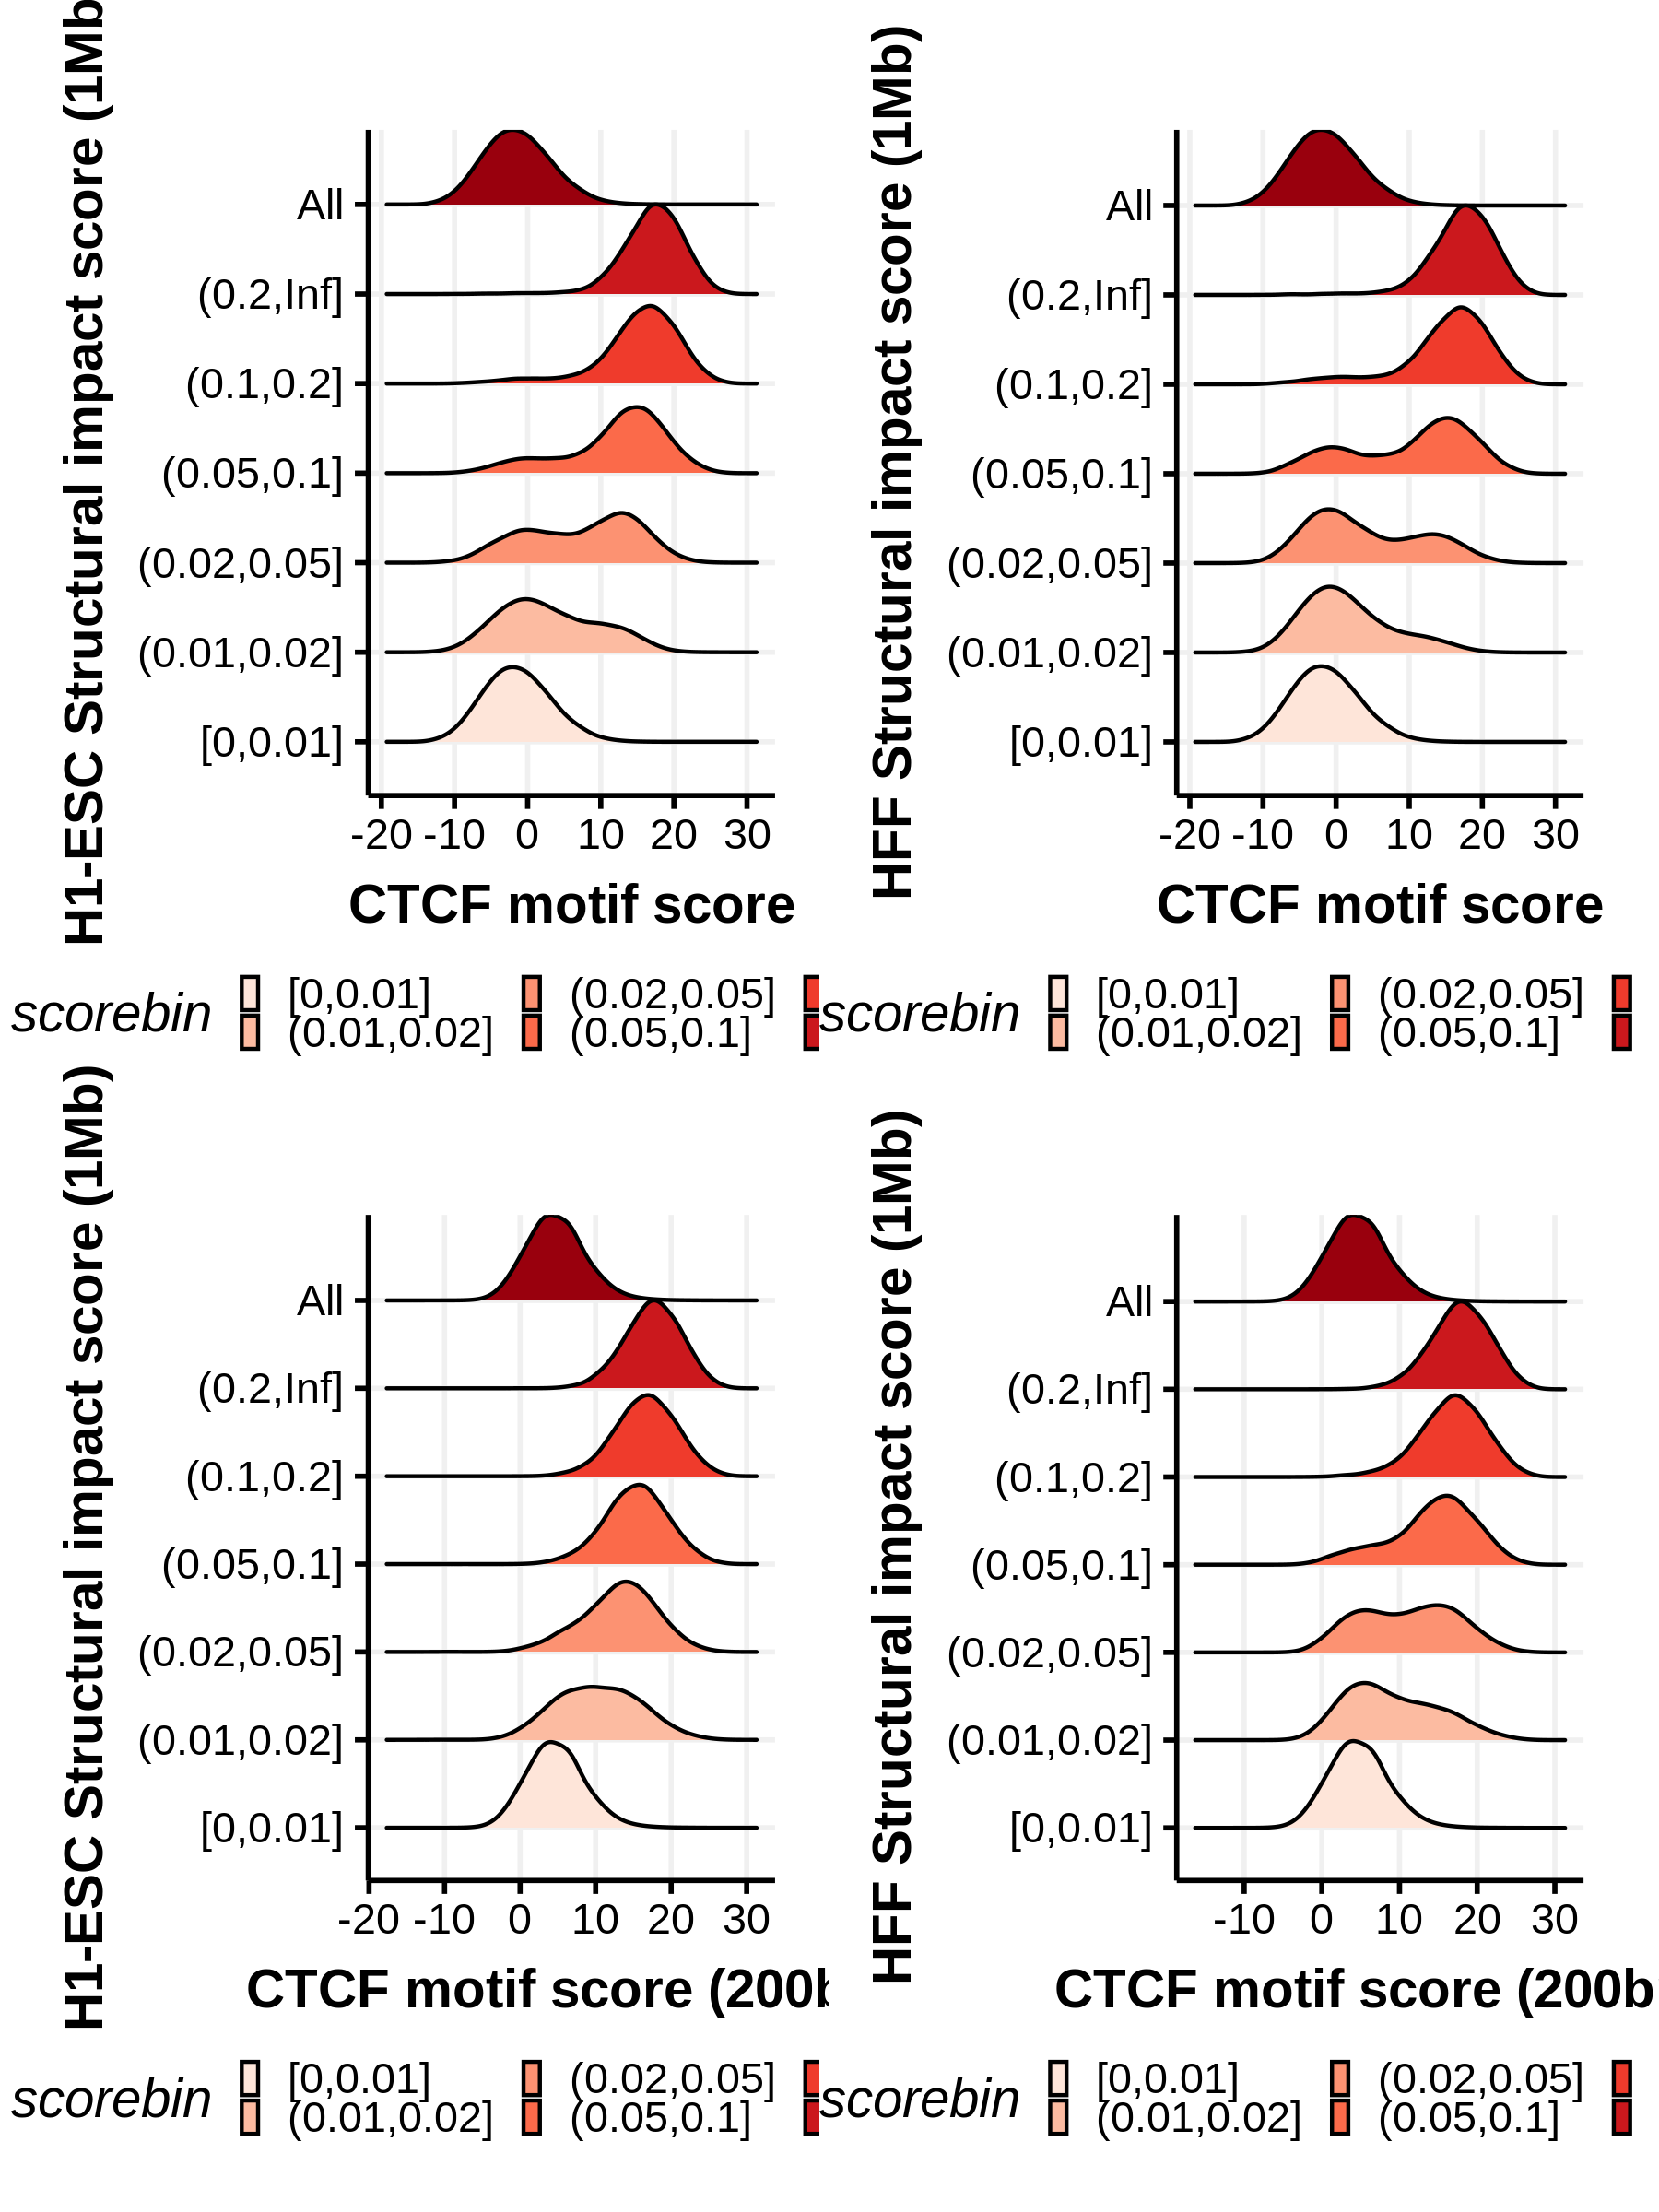

In [24]:
%%R -i plotdata,plotdata_b,plotdata2,plotdata2_b -w 6 -h 8 --units in -r 300
#CTCF motif score distributions for sites stratified with structural impact score-1Mb
#for both 10bp flanking sequence and 200bp flanking sequence 

require(ggplot2)
require(ggridges)
require(patchwork)
require(data.table)
plotdata = data.table(plotdata)
plotdata2 = data.table(plotdata2)
plotdata_b = data.table(plotdata_b)
plotdata2_b = data.table(plotdata2_b)

plotdata3 = rbind(plotdata2[score<0.01],plotdata)
plotdata3[,scorebin:=cut(score,c(0,0.01,0.02,0.05,0.1,0.2,Inf),include.lowest = T)]
plotdata3$scorebin = factor(plotdata3$scorebin, levels= c(levels(plotdata3$scorebin),"All"))
plotdata3 = rbind(plotdata3, cbind(plotdata2,scorebin="All"))

plotdata3_b = rbind(plotdata2_b[score<0.01],plotdata_b)
plotdata3_b[,scorebin:=cut(score,c(0,0.01,0.02,0.05,0.1,0.2,Inf),include.lowest = T)]
plotdata3_b$scorebin = factor(plotdata3_b$scorebin, levels= c(levels(plotdata3_b$scorebin),"All"))
plotdata3_b = rbind(plotdata3_b, cbind(plotdata2_b,scorebin="All"))



p1 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdata3, bandwidth=1., scale=1)+scale_fill_brewer(palette='Reds',direction=1)+
    theme_Publication()+xlab('CTCF motif score')+ylab('H1-ESC Structural impact score (1Mb)')
    


p2 = ggplot()+    geom_density_ridges(aes(x=motif, y=scorebin, fill=scorebin),data=plotdata3, bandwidth=1., scale=1)+scale_fill_brewer(palette='Reds',direction=1)+
    theme_Publication()+xlab('CTCF motif score (200bp)')+ylab('H1-ESC Structural impact score (1Mb)')


p3 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdata3_b, bandwidth=1., scale=1)+scale_fill_brewer(palette='Reds',direction=1)+
    theme_Publication()+xlab('CTCF motif score')+ylab('HFF Structural impact score (1Mb)')
    


p4 = ggplot()+    geom_density_ridges(aes(x=motif, y=scorebin, fill=scorebin),data=plotdata3_b, bandwidth=1., scale=1)+scale_fill_brewer(palette='Reds',direction=1)+
    theme_Publication()+xlab('CTCF motif score (200bp)')+ylab('HFF Structural impact score (1Mb)')
    

(p1 + p3) / (p2 + p4)
ggsave(filename='./figures/local_interaction.CTCF.density.pdf', width=6, heigh=8, dpi=300, device=cairo_pdf)
(p1 + p3) / (p2 + p4)

In [98]:
np.random.seed(0)

plotdata = pd.DataFrame(dict(motif=np.array(motifmatches)[:,101],motif10=np.array(motifmatches_10)[:,101], ctcf=ctcfs, score=a.loc[a['N']==False,3].values)).iloc[(np.array(motifmatches)[:,98]< 6) &  (ctcfs<4) ,:]
plotdata_b = pd.DataFrame(dict(motif=np.array(motifmatches_b)[:,559],motif10=np.array(motifmatches_b_10)[:,559], ctcf=ctcfs_b, score=b.loc[b['N']==False,3].values)).iloc[(np.array(motifmatches_b)[:,98]< 6) &  (ctcfs_b<4) ,:]
plotdata2 = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,101],motif10=np.array(motifmatches_bg_10)[:,101], ctcf=ctcfs_bg, score=a_bg.loc[a_bg['N']==False,3].values))
plotdata2 = plotdata2.iloc[np.random.permutation(plotdata2.shape[0])[:plotdata.shape[0]],:]
np.random.seed(0)
plotdata2_b = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,559],motif10=np.array(motifmatches_bg_10)[:,559], ctcf=ctcfs_bg, score=a_bg.loc[a_bg['N']==False,3].values))
plotdata2_b = plotdata2_b.iloc[np.random.permutation(plotdata2.shape[0])[:plotdata.shape[0]],:]

plotdataT = pd.DataFrame(dict(motif=np.array(motifmatches)[:,559],motif10=np.array(motifmatches_10)[:,559], ctcf=ctcfs, score=a.loc[a['N']==False,3].values)).iloc[(np.array(motifmatches)[:,98]< 6) &  (ctcfs<4) ,:]
plotdataT_b = pd.DataFrame(dict(motif=np.array(motifmatches_b)[:,101],motif10=np.array(motifmatches_b_10)[:,101], ctcf=ctcfs_b, score=b.loc[b['N']==False,3].values)).iloc[(np.array(motifmatches_b)[:,98]< 6) &  (ctcfs_b<4) ,:]
np.random.seed(0)
plotdataT2 = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,559],motif10=np.array(motifmatches_bg_10)[:,559], ctcf=ctcfs_bg, score=a_bg.loc[a_bg['N']==False,3].values))
plotdataT2 = plotdata2.iloc[np.random.permutation(plotdata2.shape[0])[:plotdata.shape[0]],:]
np.random.seed(0)
plotdataT2_b = pd.DataFrame(dict(motif=np.array(motifmatches_bg)[:,101],motif10=np.array(motifmatches_bg_10)[:,101], ctcf=ctcfs_bg, score=a_bg.loc[a_bg['N']==False,3].values))
plotdataT2_b = plotdata2_b.iloc[np.random.permutation(plotdata2.shape[0])[:plotdata.shape[0]],:]

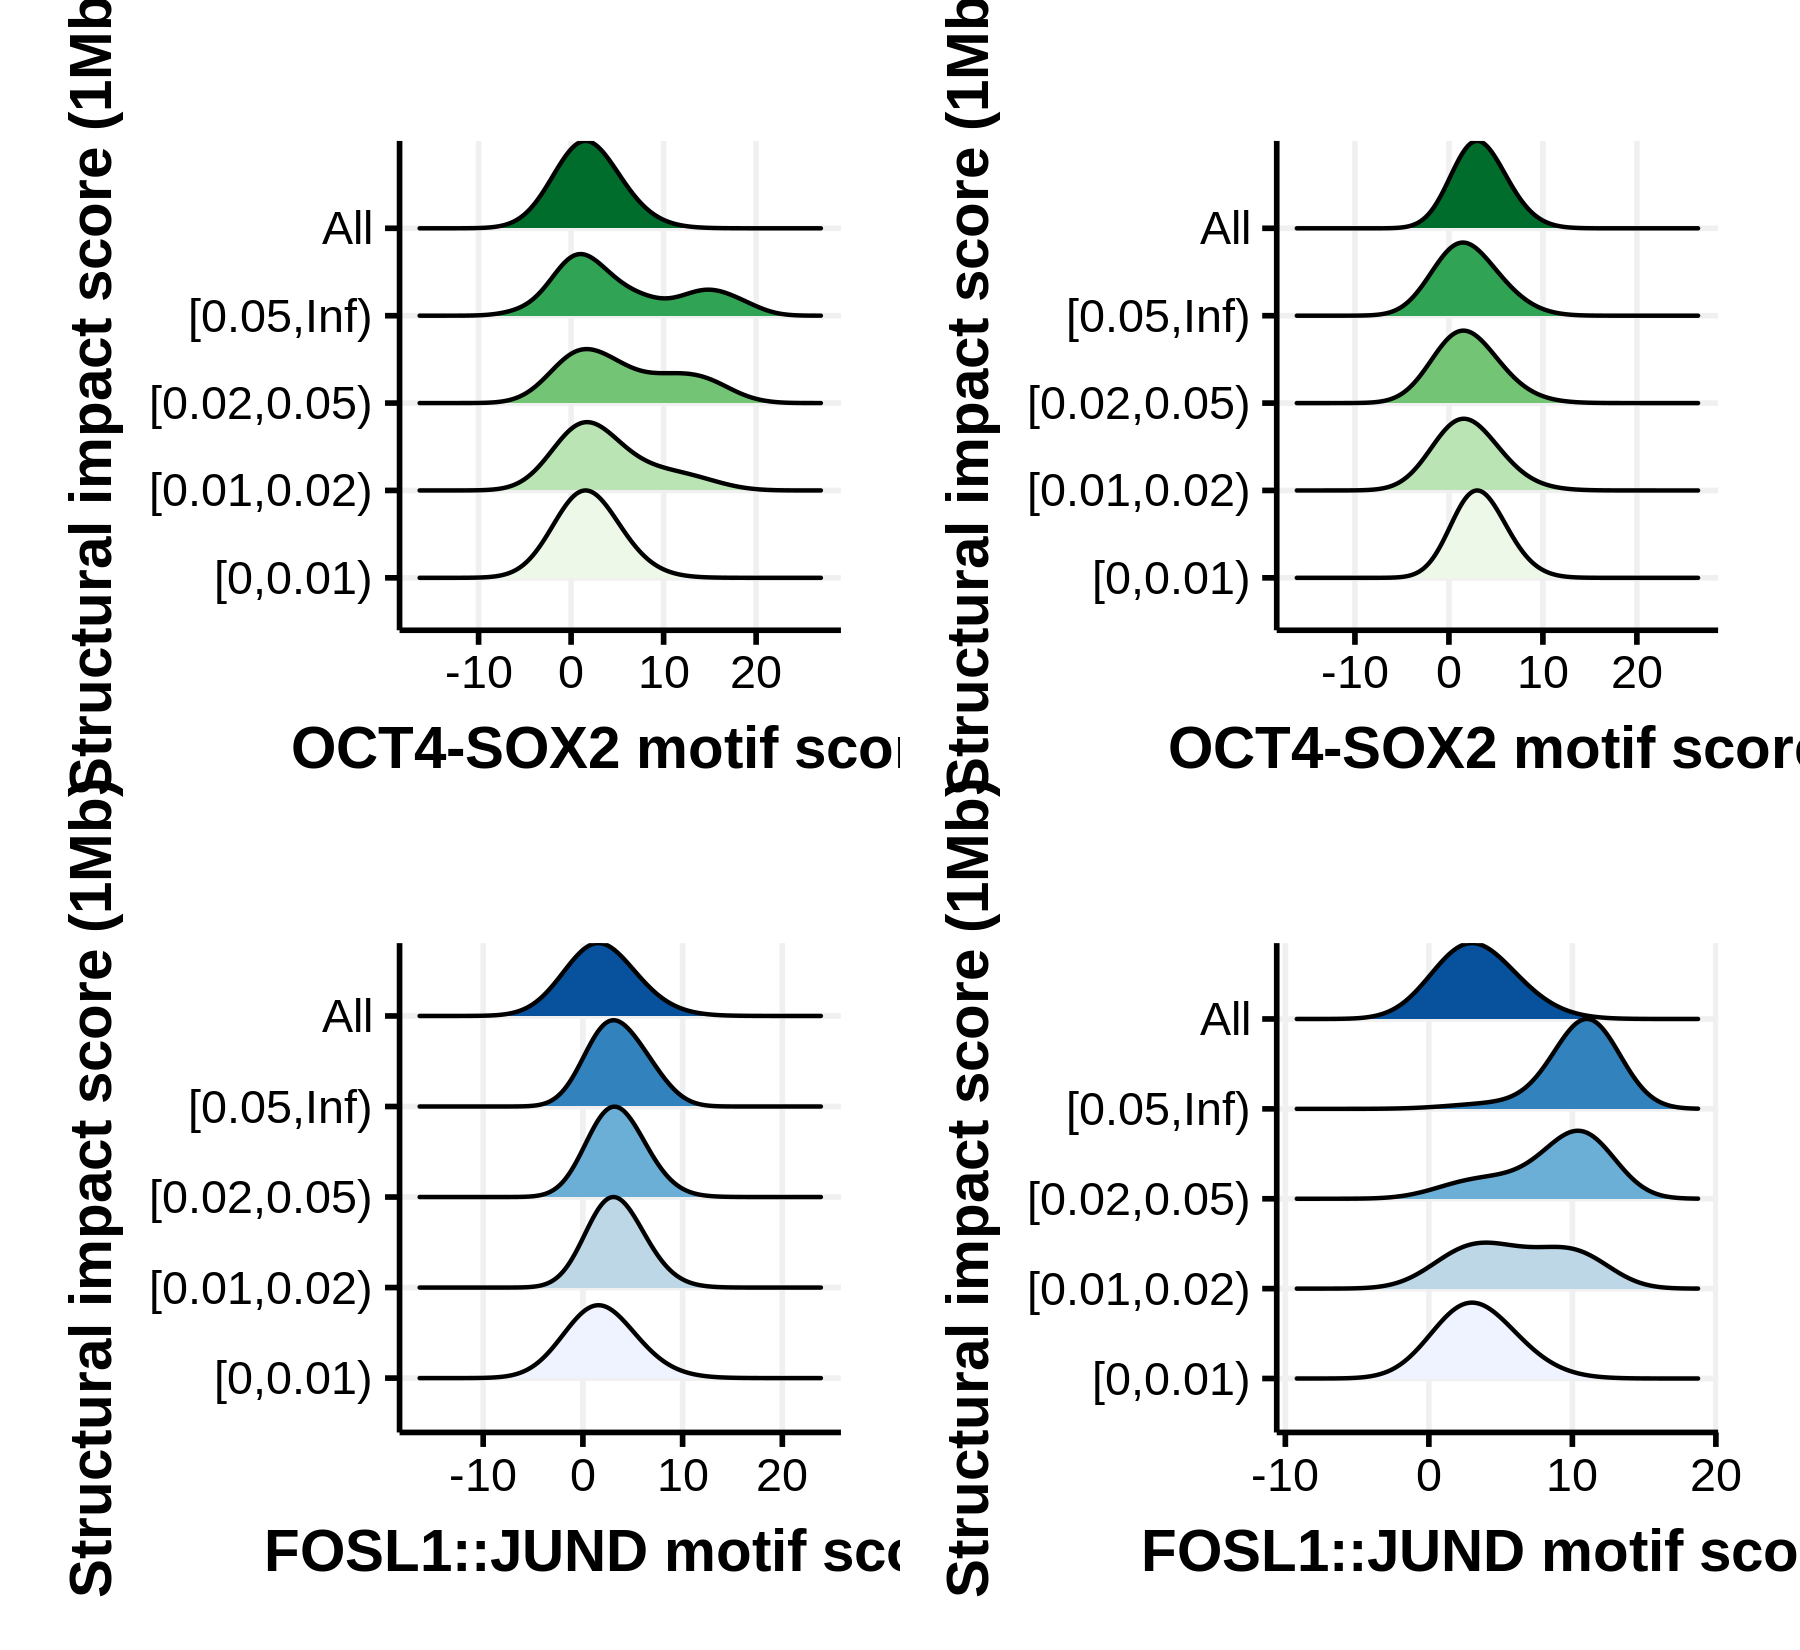

In [99]:

%%R -i plotdata,plotdata_b,plotdata2,plotdata2_b,plotdataT,plotdataT_b,plotdataT2,plotdataT2_b -w 6 -h 5.5 --units in -r 300
require(ggplot2)
require(ggridges)
require(patchwork)
require(data.table)

plotdata = data.table(plotdata)
plotdata2 = data.table(plotdata2)
plotdata2_b = data.table(plotdata2_b)

plotdata3 = rbind(plotdata2[score<0.01],plotdata)
plotdata3[,scorebin:=cut(score,c(0,0.01,0.02,0.05,Inf),right=F)]
plotdata3$scorebin = factor(plotdata3$scorebin, levels= c(levels(plotdata3$scorebin),"All"))
plotdata3 = rbind(plotdata3, cbind(plotdata2,scorebin="All"))

plotdata3_b = rbind(plotdata2_b[score<0.01],plotdata_b)
#plotdata3_b = plotdata3_b[plotdata3_b$score<0.2,] #remove only one value above 0.2
plotdata3_b[,scorebin:=cut(score,c(0,0.01,0.02,0.05,Inf),right=F)]
plotdata3_b$scorebin = factor(plotdata3_b$scorebin, levels= c(levels(plotdata3_b$scorebin),"All"))
plotdata3_b = rbind(plotdata3_b, cbind(plotdata2_b,scorebin="All"))


p1 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdata3, bandwidth=2, scale=1)+scale_fill_brewer(palette='Greens',direction=1)+
    theme_Publication()+xlab('OCT4-SOX2 motif score')+ylab('Structural impact score (1Mb)')+theme(legend.position = "none") 
    

p3 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdata3_b,  bandwidth=2, scale=1)+scale_fill_brewer(palette='Blues',direction=1)+
    theme_Publication()+xlab('FOSL1::JUND motif score')+ylab('Structural impact score (1Mb)')+theme(legend.position = "none") 

(p1 + p3)

plotdataT = data.table(plotdataT)
plotdataT2 = data.table(plotdataT2)
plotdataT2_b = data.table(plotdataT2_b)

plotdataT3 = rbind(plotdataT2[score<0.01],plotdataT)
plotdataT3[,scorebin:=cut(score,c(0,0.01,0.02,0.05,Inf),right=F)]
plotdataT3$scorebin = factor(plotdataT3$scorebin, levels= c(levels(plotdataT3$scorebin),"All"))
plotdataT3 = rbind(plotdataT3, cbind(plotdataT2,scorebin="All"))

plotdataT3_b = rbind(plotdataT2_b[score<0.01],plotdataT_b)
#plotdata3_b = plotdata3_b[plotdata3_b$score<0.2,] #remove only one value above 0.2
plotdataT3_b[,scorebin:=cut(score,c(0,0.01,0.02,0.05,Inf),right=F)]
plotdataT3_b$scorebin = factor(plotdataT3_b$scorebin, levels= c(levels(plotdataT3_b$scorebin),"All"))
plotdataT3_b = rbind(plotdataT3_b, cbind(plotdataT2_b,scorebin="All"))


p2 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdataT3_b,  bandwidth=2, scale=1)+scale_fill_brewer(palette='Greens',direction=1)+
    theme_Publication()+xlab('OCT4-SOX2 motif score')+ylab('Structural impact score (1Mb)')+theme(legend.position = "none") 
    

p4 = ggplot()+    geom_density_ridges(aes(x=motif10, y=scorebin, fill=scorebin),data=plotdataT3, bandwidth=2, scale=1)+scale_fill_brewer(palette='Blues',direction=1)+
    theme_Publication()+xlab('FOSL1::JUND motif score')+ylab('Structural impact score (1Mb)')+theme(legend.position = "none") 
    


(p1 + p2) / (p4+p3)
ggsave(filename='./figures/local_interaction.OCT4SOX2AP1.density.pdf', width=6, heigh=5.5, dpi=300, device=cairo_pdf)
(p1 + p2) / (p4+p3)

In [27]:
b_enrich_t_thresh = np.min(b_enrich_t[ (b_enrich_tp_bh<0.05)* (b_enrich_t>0)])
a_enrich_t_thresh = np.min(a_enrich_t[ (a_enrich_tp_bh<0.05)* (a_enrich_t>0)])

b_enrich_tz_thresh = np.min(b_enrich_tz[ (b_enrich_tp_bh<0.05)* (b_enrich_tz>0)])
a_enrich_tz_thresh = np.min(a_enrich_tz[ (a_enrich_tp_bh<0.05)* (a_enrich_tz>0)])

In [28]:
#Annotate motifs with clusters from https://www.vierstra.org/resources/motif_clustering
clustered_motifs = pd.read_csv('./resources/clustered_motifs.jaspar',sep='\t',header=None)
clustered_motifs['HFF']=np.nan
clustered_motifs['H1esc']=np.nan
clustered_motifs['Index']=np.nan
clustered_motifs['name']=np.nan

for i in range(clustered_motifs.shape[0]):
    try:
        clustered_motifs.loc[i,'HFF']=b_enrich_tz[motifid.index(clustered_motifs.iloc[i,0])]
        clustered_motifs.loc[i,'Index']=int(motifid.index(clustered_motifs.iloc[i,0]))
        clustered_motifs.loc[i,'name']=motifname[motifid.index(clustered_motifs.iloc[i,0])]
    except:
        pass
    
    try:
        clustered_motifs.loc[i,'H1esc']=a_enrich_tz[motifid.index(clustered_motifs.iloc[i,0])]
    except:
        pass

clustered_motifs = clustered_motifs.loc[~np.isnan(clustered_motifs['Index'])]


In [29]:
%%R -i clustered_motifs -w 5 -h 5 --units in -r 200
options(bitmapType='cairo')
require(data.table)
clustered_motifs = data.table(clustered_motifs)
clusteranno = fread('./resources/clustered_motifs.clusteranno')
clustered_motifs$cluster_name   = clusteranno$Name[match(clustered_motifs$`6`,clusteranno$Cluster_ID)]
clustered_motifs$cluster_dbd   = clusteranno$DBD[match(clustered_motifs$`6`,clusteranno$Cluster_ID)]

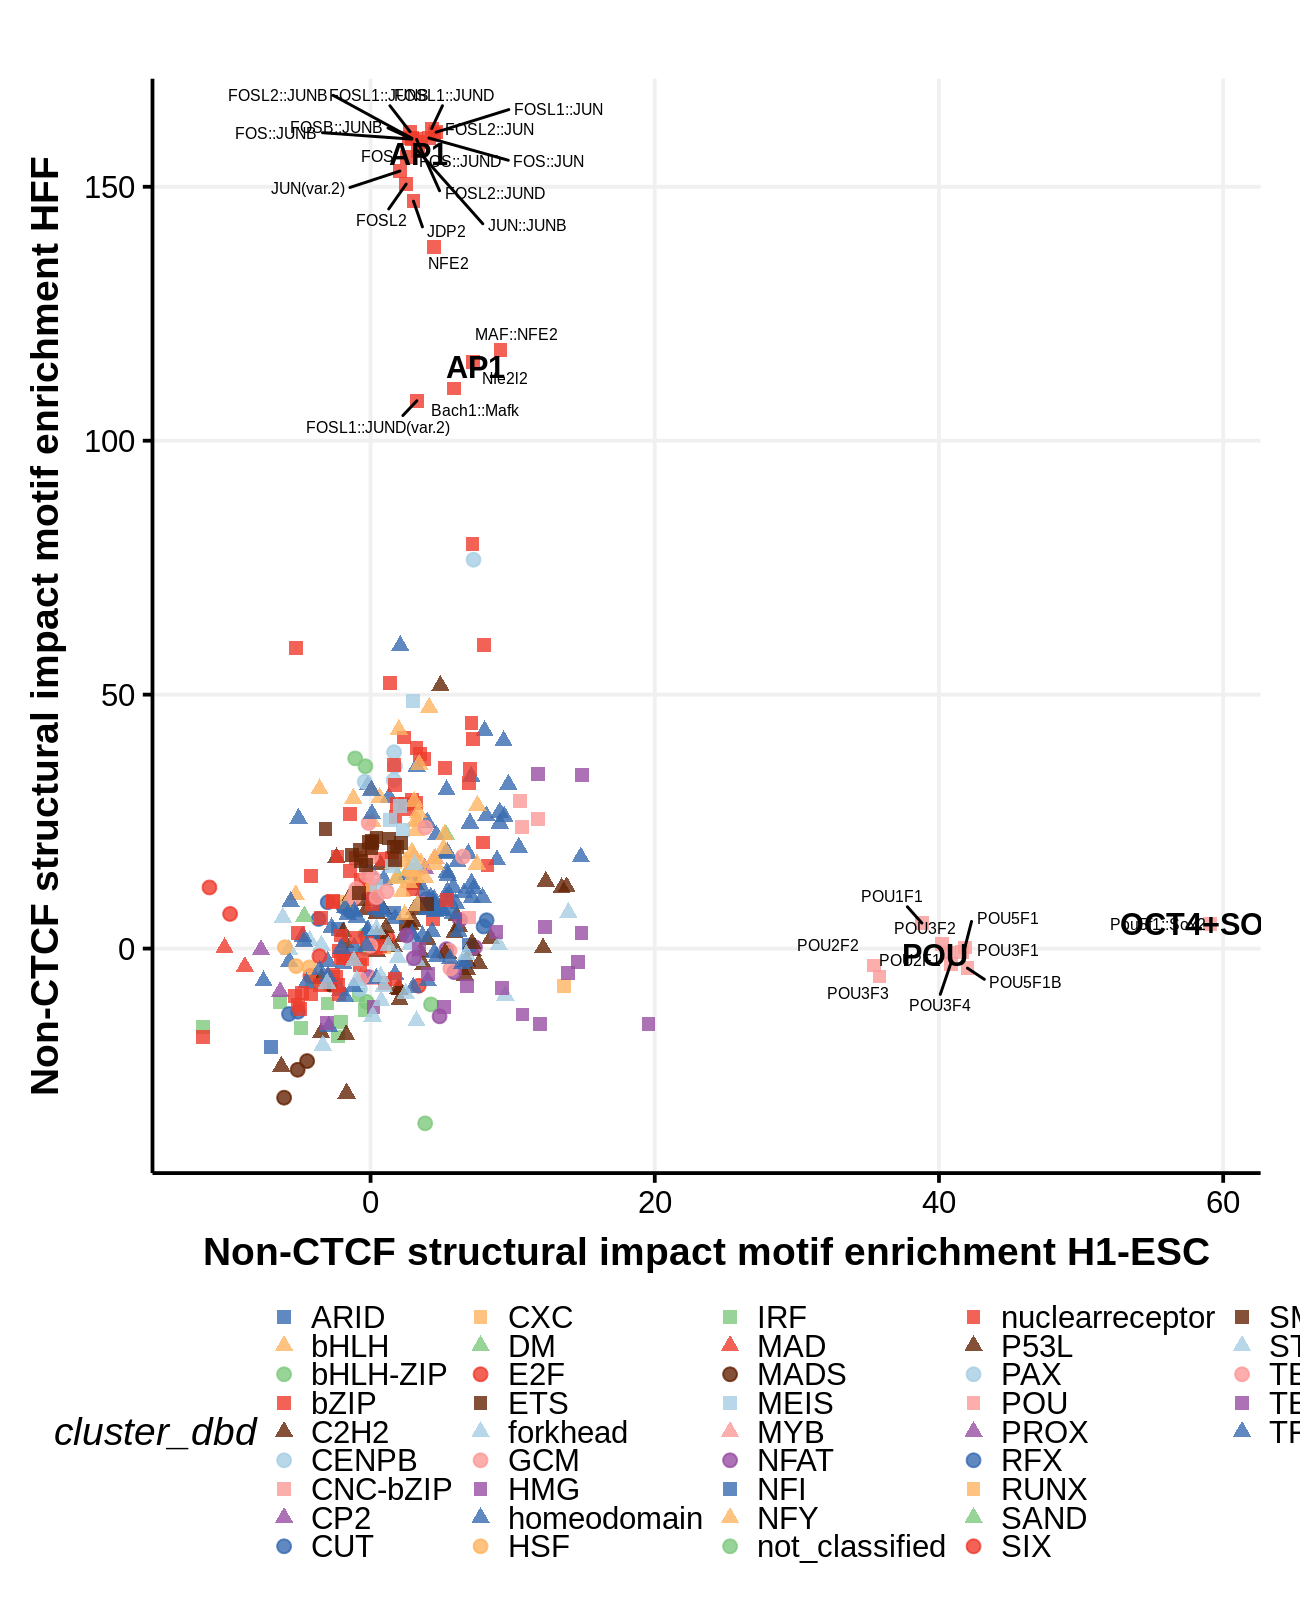

In [97]:
%%R  -i b_enrich_t_thresh,a_enrich_t_thresh -w 6.5 -h 8 --units in -r 200
#Plot motif enrichment comparisons between HFF and H1-ESC

require(ggrepel)
clustered_motifs[,HFF_group := mean(HFF),by='6']
clustered_motifs[,H1esc_group := mean(H1esc),by='6']
clustered_motifs_group = clustered_motifs[,.SD[1,],by='6']
require(ggplot2)
require(ggrepel)
p = ggplot()+geom_point(aes(y=HFF, x=H1esc, color=cluster_dbd, shape=cluster_dbd),
                    data=data.table(clustered_motifs),alpha=I(0.8), size=2)+
    geom_text(aes(y=HFF_group, x=H1esc_group,label=gsub('/.*','',cluster_name)),
                        data=clustered_motifs_group[H1esc_group>30|HFF_group>100,],fontface='bold')+
    geom_text_repel(aes(y=HFF, x=H1esc, label=name),
                    data=data.table(clustered_motifs)[(HFF>=100)|(H1esc>=30),], force=0.02, size=(2))+
    scale_shape_manual(values = rep(c(15,17,19), 30))+
    scale_colour_manual(values=rep(c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3"), 30))+
    theme_Publication()+ylab('Non-CTCF structural impact motif enrichment HFF')+
    xlab('Non-CTCF structural impact motif enrichment H1-ESC')
p
ggsave('./figures/local_interaction.nonCTCF.h1escvshff.pdf',device=cairo_pdf)
p

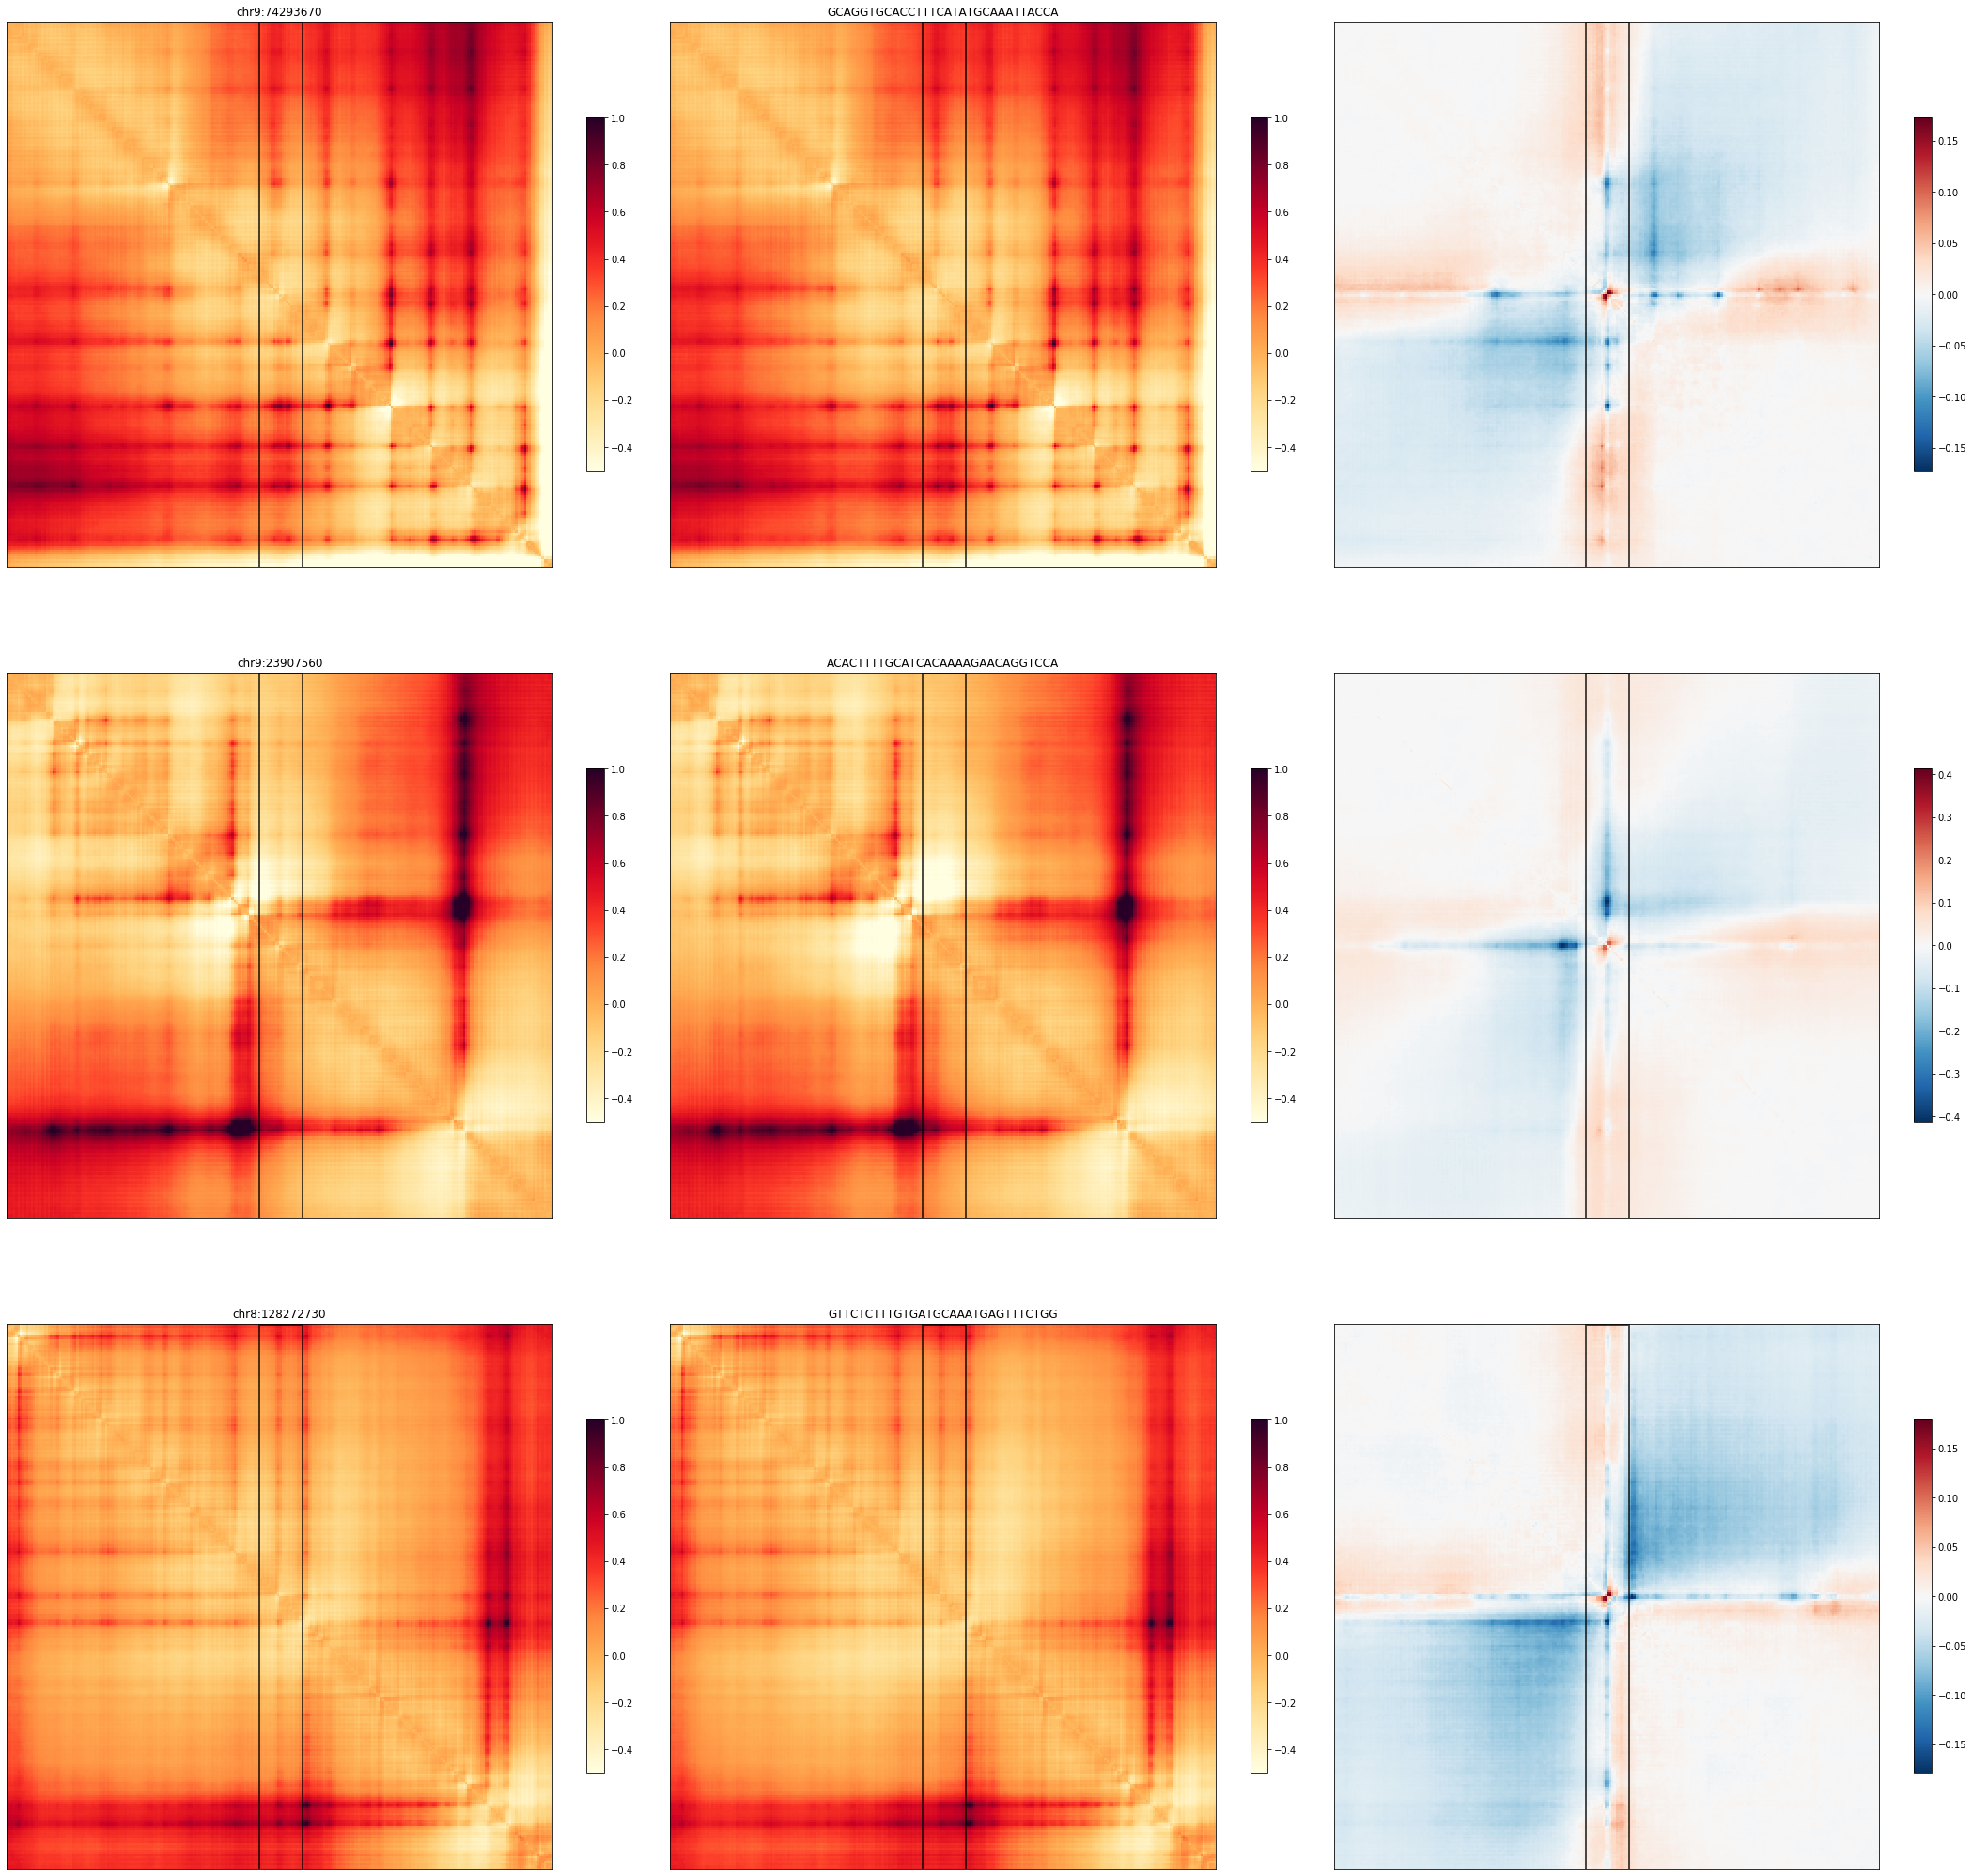

In [96]:
#individual motif discruption examples for POU5F1::SOX1
import matplotlib
%matplotlib inline
from colormaps import hnh_cmap_ext5
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def pred_1m(seq, model):
    pred,_ = model.net.forward(seq.transpose(1,2))
    return pred

np.random.seed(0)
figsize(30,30)
fig,axes = plt.subplots(3,3)
for i, (chrm, start) in enumerate([['chr9', 74293670],['chr9', 23907560],['chr8', 128272730]]):
    sequence = hg38.get_encoding_from_coords(chrm, start-500000,  start+500000)[None,:,:] 

    pred = pred_1m(torch.FloatTensor(sequence).cuda(),h1esc_1m).squeeze().detach().cpu().numpy()
    predhff = pred_1m(torch.FloatTensor(sequence).cuda(),hff_1m).squeeze().detach().cpu().numpy()

    sequence_mut = sequence.copy()
    sequence_mut[0,500000:500010,:]=sequence[0,np.random.randint(0,sequence.shape[1],10),:]
    pred_mut = pred_1m(torch.FloatTensor(sequence_mut).cuda(),h1esc_1m).squeeze().detach().cpu().numpy()
    predhff_mut = pred_1m(torch.FloatTensor(sequence_mut).cuda(),hff_1m).squeeze().detach().cpu().numpy()

    target = np.log((target_h1esc.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + h1esc_1m.epss[1])/(h1esc_1m.normmats[1] + h1esc_1m.epss[1]))

    
    img = axes[i][0].imshow(pred[:,:], cmap=hnh_cmap_ext5, vmin=-0.5, vmax=1., interpolation=None)
    axes[i][0].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7,
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][0],shrink=0.5)
    axes[i][0].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)
    axes[i][0].set_title(chrm+':'+str(start))


    img = axes[i][1].imshow(pred_mut[:,:], cmap=hnh_cmap_ext5, vmin=-0.5, vmax=1., interpolation=None)
    axes[i][1].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7,
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][1],shrink=0.5)
    axes[i][1].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)
    axes[i][1].set_title(hg38.get_sequence_from_coords(chrm, start-10,start+20))


    max_abs_img = np.max(np.abs(pred_mut-pred))
    img = axes[i][2].imshow(pred_mut-pred, cmap='RdBu_r', interpolation=None, vmin=-max_abs_img, vmax=max_abs_img)
    
    axes[i][2].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7,
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][2],shrink=0.5)
    axes[i][2].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)



plt.tight_layout()
plt.savefig('./figures/local_interaction.nonCTCF.oct4sox2.examples.pdf')

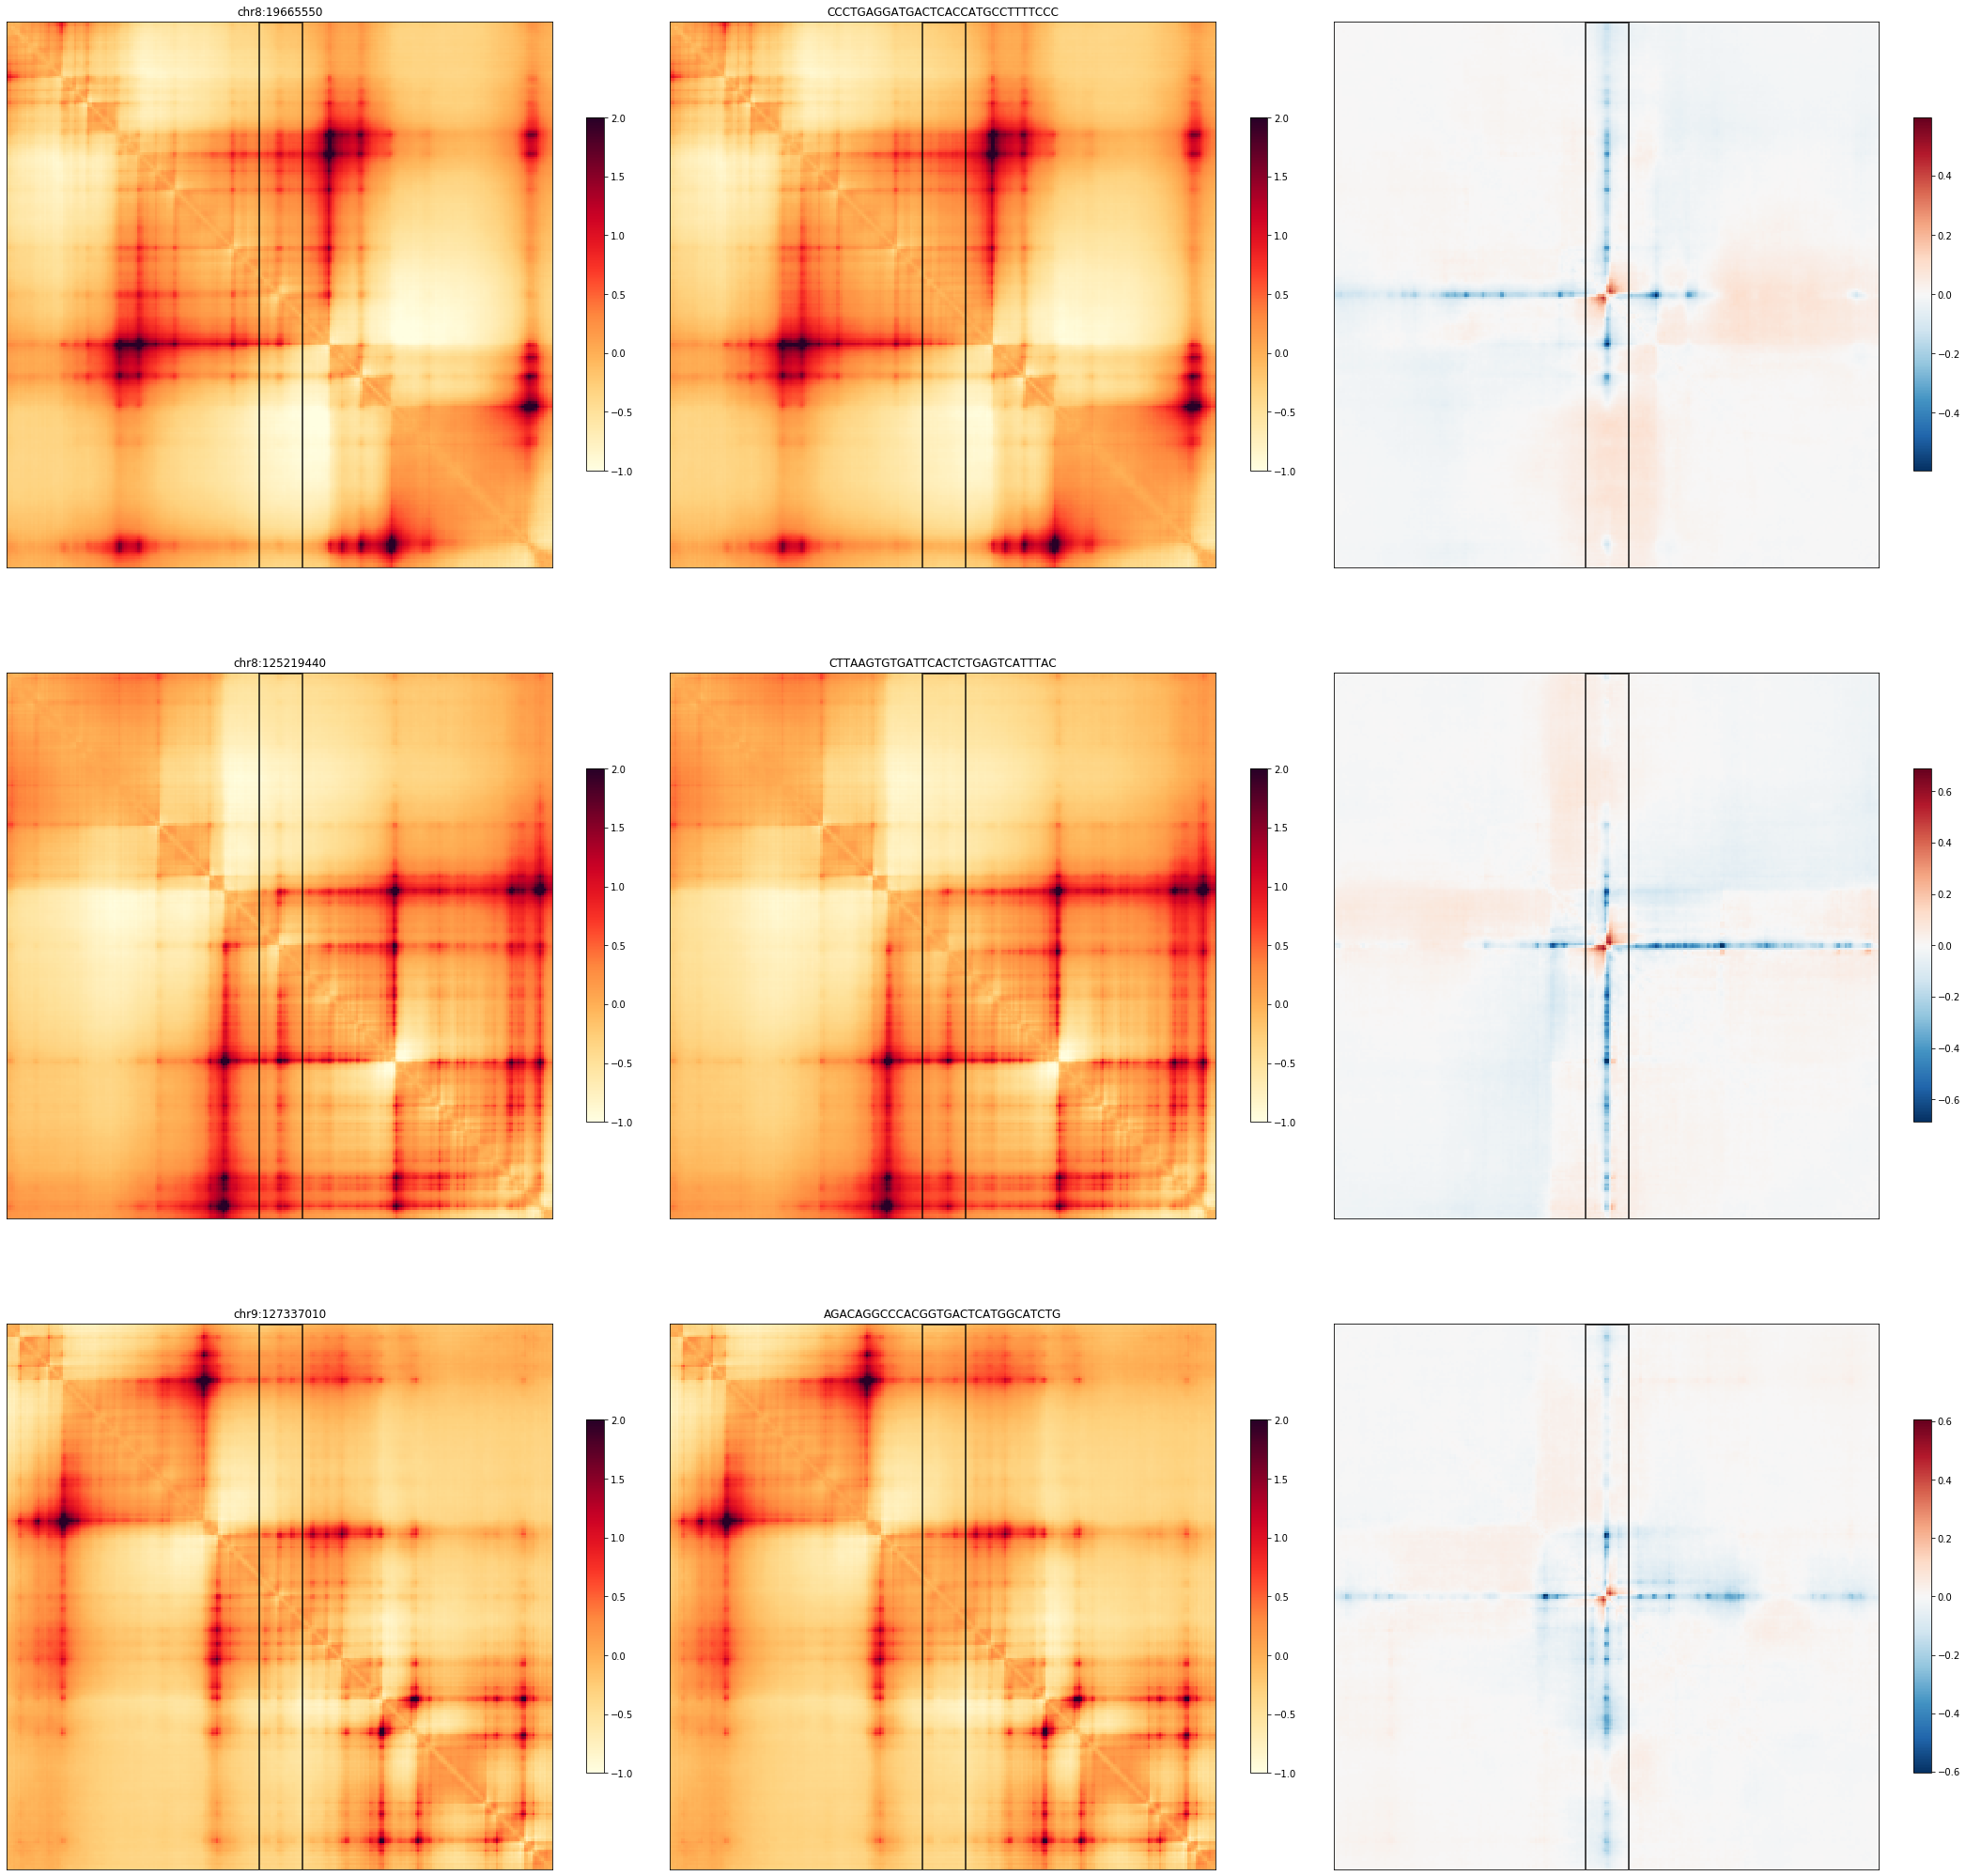

In [95]:
#individual motif discruption examples for AP1 motif

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
np.random.seed(0)
figsize(30,30)
fig,axes = plt.subplots(3,3)
for i, (chrm, start) in enumerate([['chr8', 19665550],['chr8', 125219440],['chr9', 127337010]]):
    sequence = hg38.get_encoding_from_coords(chrm, start-500000,  start+500000)[None,:,:] 

    pred = pred_1m(torch.FloatTensor(sequence).cuda(),hff_1m).squeeze().detach().cpu().numpy()

    sequence_mut = sequence.copy()
    sequence_mut[0,500000:500010,:]=sequence[0,np.random.randint(0,sequence.shape[1],10),:]
    pred_mut = pred_1m(torch.FloatTensor(sequence_mut).cuda(),hff_1m).squeeze().detach().cpu().numpy()

    target = np.log((target_hff.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + h1esc_1m.epss[1])/(h1esc_1m.normmats[1] + h1esc_1m.epss[1]))

    
    img = axes[i][0].imshow(pred[:,:], cmap=hnh_cmap_ext5, vmin=-1, vmax=2, interpolation=None)
    axes[i][0].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7,
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][0],shrink=0.5)
    axes[i][0].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)
    axes[i][0].set_title(chrm+':'+str(start))


    img = axes[i][1].imshow(pred_mut[:,:], cmap=hnh_cmap_ext5, vmin=-1, vmax=2, interpolation=None)
    axes[i][1].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7,
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][1],shrink=0.5)
    axes[i][1].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)
    axes[i][1].set_title(hg38.get_sequence_from_coords(chrm, start-10,start+20))


    max_abs_img = np.max(np.abs(pred_mut-pred))
    img = axes[i][2].imshow(pred_mut-pred, cmap='RdBu_r', interpolation=None, vmin=-max_abs_img, vmax=max_abs_img)
    
    axes[i][2].add_patch(matplotlib.patches.Rectangle((115,0), 20, 250, angle=0.0, alpha=0.7, 
                                              color='#000000',fill=False, linewidth=2))
    plt.colorbar(img, ax=axes[i][2],shrink=0.5)
    axes[i][2].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False,left=False)




plt.tight_layout()
plt.savefig('./figures/local_interaction.nonCTCF.ap1.examples.pdf')

In [33]:
oct4sox2_targets =  a[a['N']==False].iloc[(motifmatches_10[:, 101]>10) &  (a[a['N']==False][3].values > 0.02)  & (np.array(motifmatches)[:,98]<6) & (ctcfs<4),:]

In [34]:
ctcf_targets =  a[a['N']==False].iloc[(motifmatches_10[:, 98]>10) &  (a[a['N']==False][3].values > 0.1),:]

In [35]:
targets=[]
target_h1esc.cg=False
for i, (chrm, start) in enumerate(zip(oct4sox2_targets.iloc[:,0], oct4sox2_targets.iloc[:,1])):
    try:
        target = np.log((target_h1esc.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*h1esc_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_h1esc.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_oct4sox2_h1esc = np.nanmean(targets, axis=0)-targets_norm
targets_oct4sox2_h1esc = 0.5 * targets_oct4sox2_h1esc + 0.5*targets_oct4sox2_h1esc[::-1,::-1]

In [36]:
targets=[]
target_h1esc.cg=False
for i, (chrm, start) in enumerate(zip(ctcf_targets.iloc[:,0], ctcf_targets.iloc[:,1])):
    try:
        target = np.log((target_h1esc.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*h1esc_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_h1esc.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ctcf_h1esc = np.nanmean(targets, axis=0)-targets_norm
targets_ctcf_h1esc = 0.5 * targets_ctcf_h1esc + 0.5*targets_ctcf_h1esc[::-1,::-1]

In [37]:
targets=[]
target_hff.cg=False
for i, (chrm, start) in enumerate(zip(oct4sox2_targets.iloc[:,0], oct4sox2_targets.iloc[:,1])):
    try:
        target = np.log((target_hff.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*hff_1m.epss[1])/(hff_1m.normmats[1] + 1*hff_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_hff.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_oct4sox2_hff = np.nanmean(targets, axis=0)-targets_norm
targets_oct4sox2_hff = 0.5 * targets_oct4sox2_hff + 0.5*targets_oct4sox2_hff[::-1,::-1]

In [38]:
targets=[]
target_hff.cg=False
for i, (chrm, start) in enumerate(zip(ctcf_targets.iloc[:,0], ctcf_targets.iloc[:,1])):
    try:
        target = np.log((target_hff.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*hff_1m.epss[1])/(hff_1m.normmats[1] + 1*hff_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_hff.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ctcf_hff = np.nanmean(targets, axis=0)-targets_norm
targets_ctcf_hff = 0.5 * targets_ctcf_hff + 0.5*targets_ctcf_hff[::-1,::-1]

In [39]:
ap1_targets =  b[b['N']==False].iloc[(motifmatches_b[:, 559]>10) &  (b[b['N']==False][3].values > 0.02)  & (np.array(motifmatches_b)[:,98]<6) & (ctcfs_b<4),:]

In [40]:
ctcfb_targets =  b[b['N']==False].iloc[(motifmatches_b_10[:, 98]>10) &  (b[b['N']==False][3].values > 0.1),:]

In [41]:
targets=[]
target_hff.cg=False
for i, (chrm, start) in enumerate(zip(ap1_targets.iloc[:,0], ap1_targets.iloc[:,1])):
    try:
        target = np.log((target_hff.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*hff_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_hff.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ap1_hff = np.nanmean(targets, axis=0)-targets_norm
targets_ap1_hff = 0.5 * targets_ap1_hff + 0.5*targets_ap1_hff[::-1,::-1]

In [42]:
targets=[]
target_hff.cg=False
for i, (chrm, start) in enumerate(zip(ctcfb_targets.iloc[:,0], ctcfb_targets.iloc[:,1])):
    try:
        target = np.log((target_hff.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*hff_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_hff.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ctcfb_hff = np.nanmean(targets, axis=0)-targets_norm
targets_ctcfb_hff = 0.5 * targets_ctcfb_hff + 0.5*targets_ctcfb_hff[::-1,::-1]

In [43]:
targets=[]
target_h1esc.cg=False
for i, (chrm, start) in enumerate(zip(ap1_targets.iloc[:,0], ap1_targets.iloc[:,1])):
    try:
        target = np.log((target_h1esc.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*h1esc_1m.epss[1])/(h1esc_1m.normmats[1] + 1*h1esc_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_h1esc.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ap1_h1esc = np.nanmean(targets, axis=0)-targets_norm
targets_ap1_h1esc = 0.5 * targets_ap1_h1esc + 0.5*targets_ap1_h1esc[::-1,::-1]

In [44]:
targets=[]
target_h1esc.cg=False
for i, (chrm, start) in enumerate(zip(ctcfb_targets.iloc[:,0], ctcfb_targets.iloc[:,1])):
    try:
        target = np.log((target_h1esc.get_feature_data(chrm, start-500000,  start+500000 )[:250,:250] + 1*h1esc_1m.epss[1])/(h1esc_1m.normmats[1] + 1*h1esc_1m.epss[1]))
        targets.append(target)
    except:
        pass

target_h1esc.cg=True
targets_norm=np.array([np.nanmean([np.diag(t,k=k) for t in targets]) for k in range(250)])[np.abs(np.arange(250)[:,None]-np.arange(250)[None,:])]
targets_ctcfb_h1esc = np.nanmean(targets, axis=0)-targets_norm
targets_ctcfb_h1esc = 0.5 * targets_ctcfb_h1esc + 0.5*targets_ctcfb_h1esc[::-1,::-1]

In [45]:
torch.save({'targets_ap1_h1esc':targets_ap1_h1esc, 'targets_ap1_hff':targets_ap1_hff, 
            'targets_ctcfb_h1esc':targets_ctcfb_h1esc, 'targets_ctcfb_hff':targets_ctcfb_hff,
           'targets_oct4sox2_h1esc':targets_oct4sox2_h1esc, 'targets_oct4sox2_hff':targets_oct4sox2_hff,
           'targets_ctcf_h1esc':targets_ctcf_h1esc, 'targets_ctcf_hff':targets_ctcf_hff}, './figure_data/targets.pileups.pth')

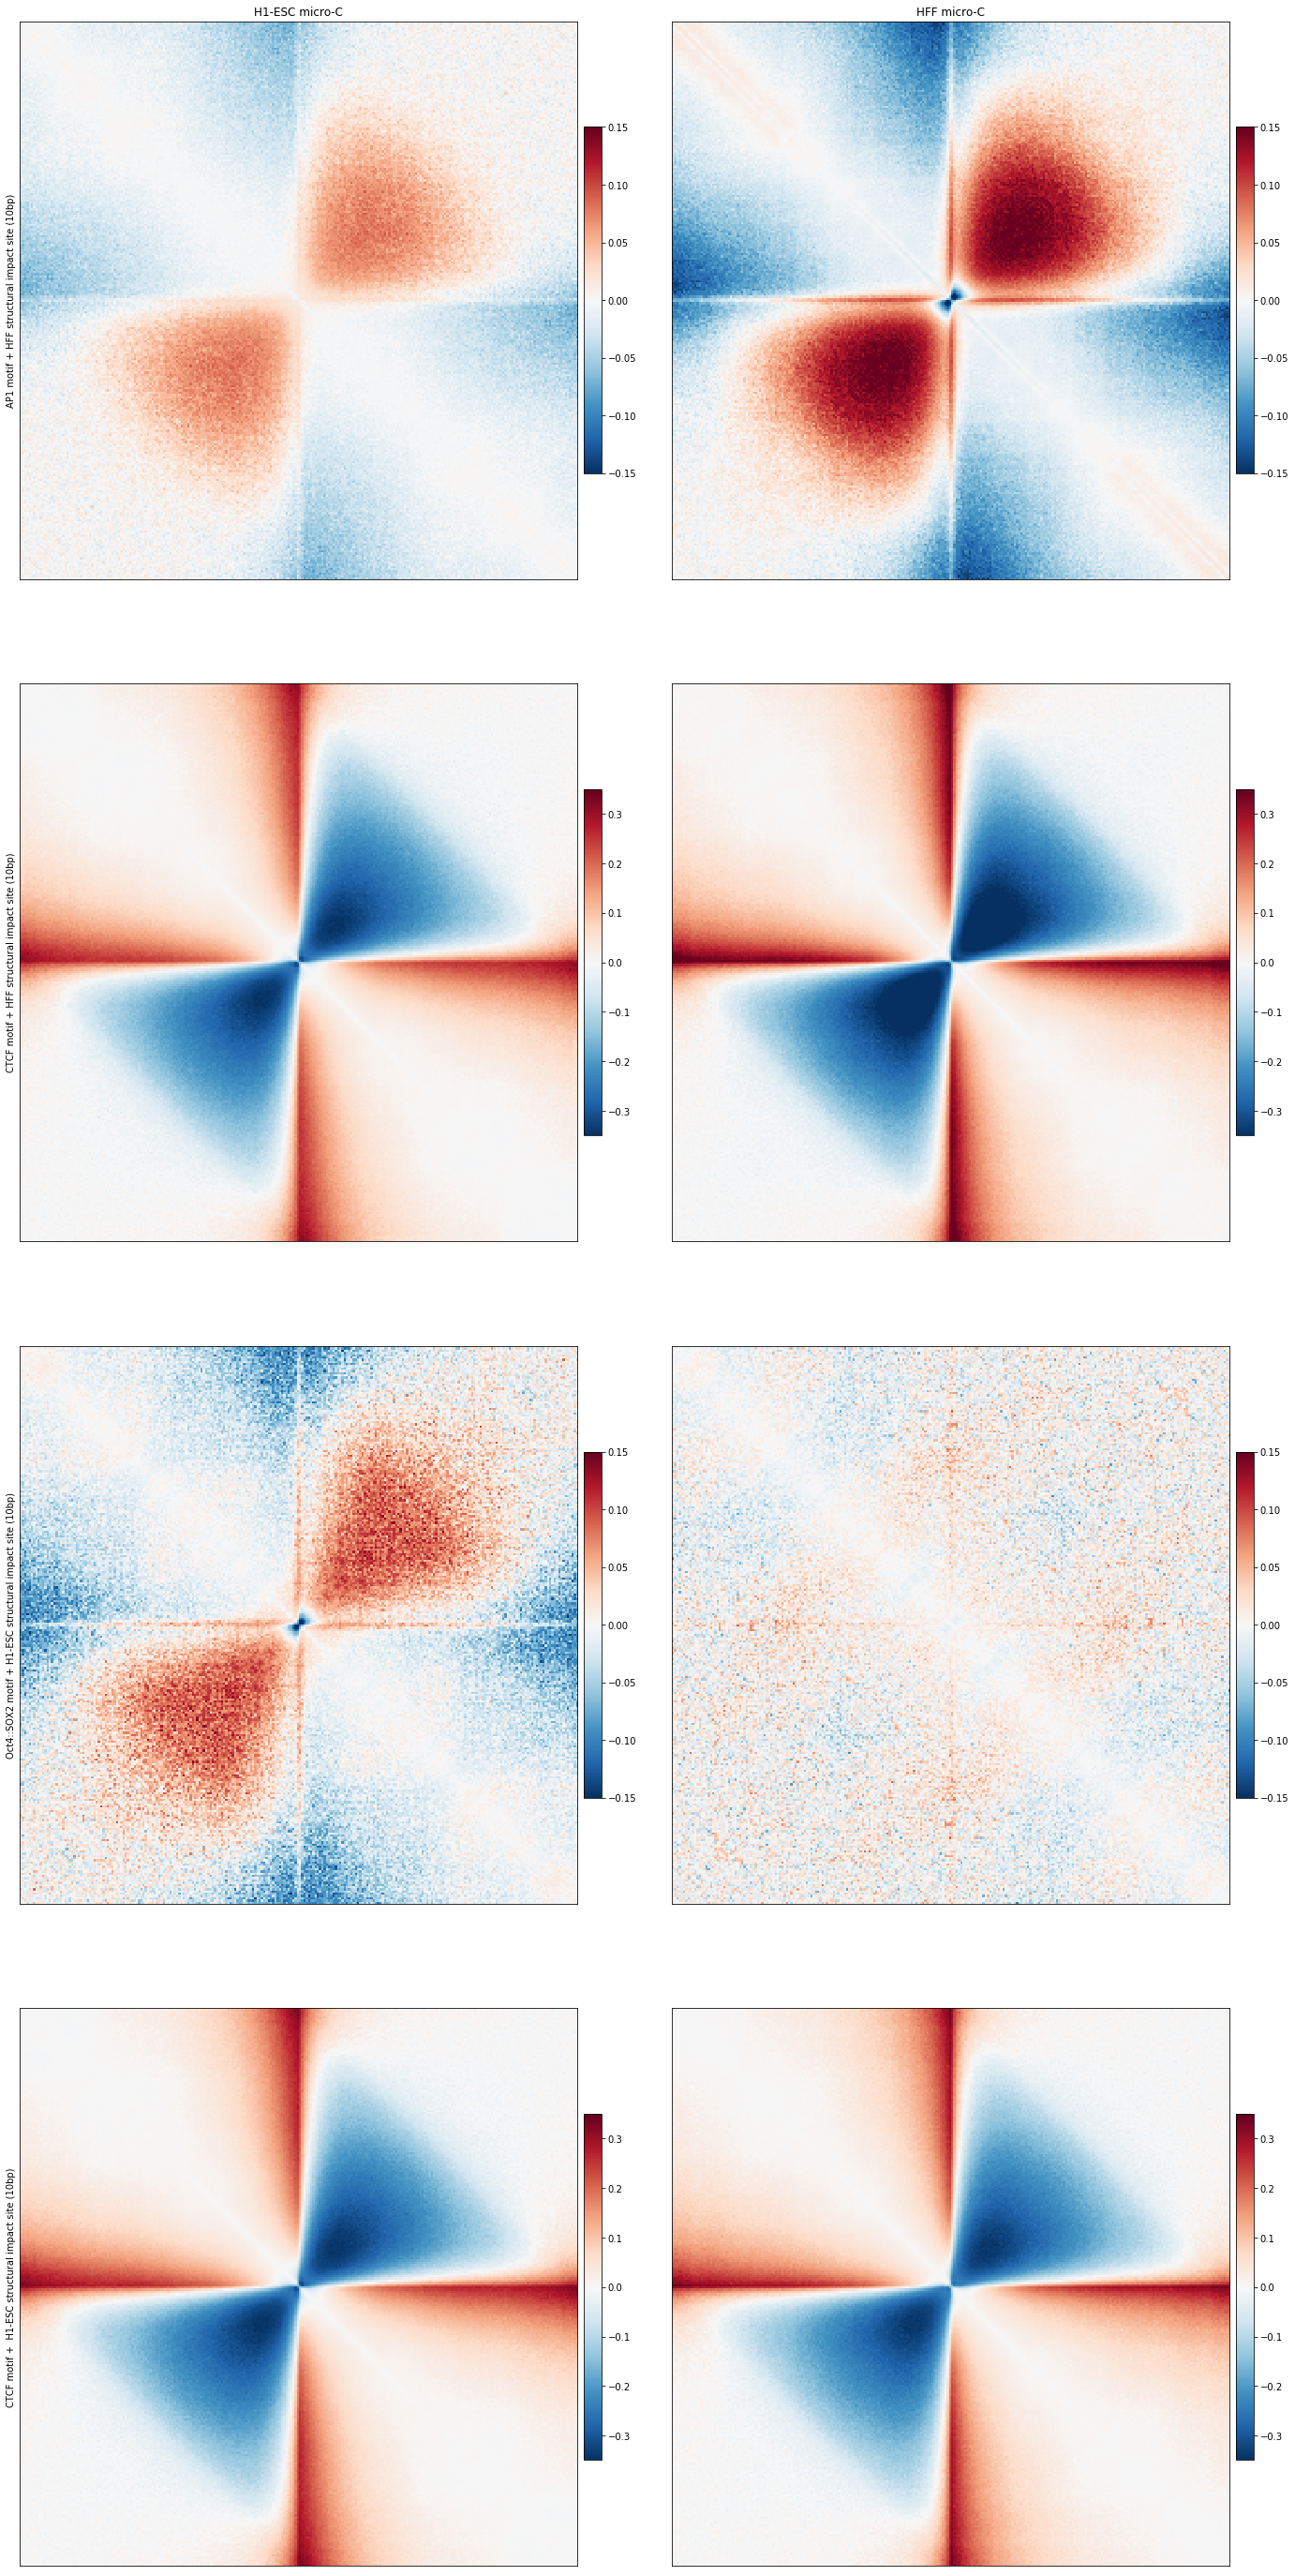

In [46]:
#Pile-up plots for micro-C data in H1-ESC and HFF
#for AP1, POU5F1::SOX2, and CTCF motif sites with local structural impact (>0.02 for AP1 and POU5F1::Sox2, >0.1 for CTCF)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, all_axes = plt.subplots(figsize=(10*2, 10*4 ), nrows=4, ncols=2)
for row_axes in all_axes:
    for ax in row_axes:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

im=all_axes[0][0].imshow(targets_ap1_h1esc, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
fig.colorbar(im, ax=all_axes[0][0], shrink=0.5, pad=0.01)
all_axes[0][0].set_title('H1-ESC micro-C')
all_axes[0][0].set_ylabel('AP1 motif + HFF structural impact site (10bp)')

im=all_axes[0][1].imshow(targets_ap1_hff, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
fig.colorbar(im, ax=all_axes[0][1], shrink=0.5, pad=0.01)
all_axes[0][1].set_title('HFF micro-C')

im=all_axes[1][0].imshow(targets_ctcfb_h1esc, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
fig.colorbar(im, ax=all_axes[1][0], shrink=0.5, pad=0.01)
all_axes[1][0].set_ylabel('CTCF motif + HFF structural impact site (10bp)')

im=all_axes[1][1].imshow(targets_ctcfb_hff, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
fig.colorbar(im, ax=all_axes[1][1], shrink=0.5, pad=0.01)

im=all_axes[2][0].imshow(targets_oct4sox2_h1esc, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
fig.colorbar(im, ax=all_axes[2][0], shrink=0.5, pad=0.01)
all_axes[2][0].set_ylabel('Oct4::SOX2 motif + H1-ESC structural impact site (10bp)')

im=all_axes[2][1].imshow(targets_oct4sox2_hff, cmap='RdBu_r',  vmin=-0.15, vmax=0.15)
fig.colorbar(im, ax=all_axes[2][1], shrink=0.5, pad=0.01)

im=all_axes[3][0].imshow(targets_ctcf_h1esc, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
fig.colorbar(im, ax=all_axes[3][0], shrink=0.5, pad=0.01)
all_axes[3][0].set_ylabel('CTCF motif +  H1-ESC structural impact site (10bp)')

im=all_axes[3][1].imshow(targets_ctcf_hff, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
fig.colorbar(im, ax=all_axes[3][1], shrink=0.5, pad=0.01)
plt.tight_layout()

plt.savefig('./figures/local_interaction.microCpileup.ap1.oct4sox2.ctcf.pdf')

INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [bigwig file test]
INFO:pygenometracks.tracksClass:initialize 4. [bigwig file test]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.008980989456176758
DEBUG:pygenometracks.tracksClass:Figure size in cm is 30.0 x 8.03191489361702. Dpi is set to 300

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [bigwig file test]
INFO:pygenometracks.tracksClass:plotting 4. [bigwig file test]


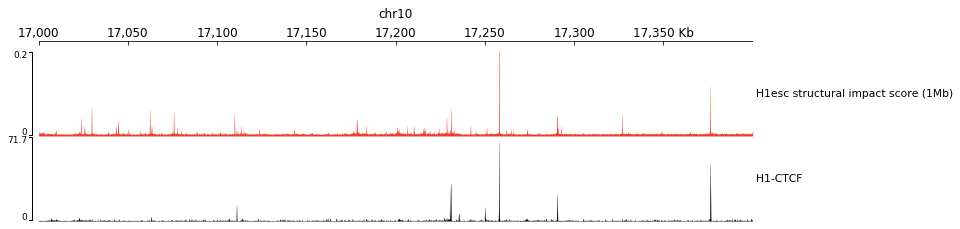

In [48]:
#example genome browser visualization of structural impact score-1Mb and CTCF binding
browser_tracks = """
[x-axis]
where = top
fontsize = 12
[spacer]
height = 0.05




[bigwig file test]
file = ./figure_data/local_interaction.hff_1m.bedgraph.sorted.bw
# height of the track in cm (optional value)
height = 3
title = H1esc structural impact score (1Mb)
summary_method = max
file_type = bigwig
number_of_bins = 2000
color = black
min_value = 0
max_value = 0.2
color=#EE3C2D

[bigwig file test]
file = ../orca/extra/H1_CTCF_ENCFF147GRN.bigWig
height = 3
title = H1-CTCF
summary_method = max
file_type = bigwig
min_value = 0
number_of_bins = 2000
color=#000000




"""


with open("/dev/shm/temp.ini", 'w') as fh:
    fh.write(browser_tracks)

regionstr = 'chr10:17000000-17400000'

import pygenometracks.plotTracks
import uuid
filename = str(uuid.uuid4())
args = f"--tracks /dev/shm/temp.ini --region {regionstr} "\
       "--trackLabelFraction 0.03 --width 30 --dpi 300 "\
       f"--outFileName ./figures/local_interaction.gbrowser.pdf".split()
_ = pygenometracks.plotTracks.main(args)



In [49]:
#Comparison of CTCF with Structural impact score - 1Mb for cohesin-depleted HCT119 model:

import pyBigWig
bw = pyBigWig.open(ORCA_PATH + "/extra/HCT116_CTCF_ENCFF115GQW.bigWig")
ctcf_hct116 = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
ctcf_hct116 += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
ctcf_hct116 += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

bw = pyBigWig.open("./figure_data/local_interaction.hctnoc_1m.bedgraph.sorted.bw")
score_hct116 = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
score_hct116 += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
score_hct116 += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

In [50]:
bw = pyBigWig.open(ORCA_PATH + "/extra/H1_CTCF_ENCFF147GRN.bigWig")
ctcf_h1esc = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
ctcf_h1esc += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
ctcf_h1esc += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

bw = pyBigWig.open("./figure_data/local_interaction.h1esc_1m.bedgraph.sorted.bw")
score_h1esc = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
score_h1esc += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
score_h1esc += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

In [51]:
bw = pyBigWig.open(ORCA_PATH + "/extra/foreskin_fibroblast_CTCF_ENCFF938TJR.bigWig")
ctcf_hff = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
ctcf_hff += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
ctcf_hff += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

bw = pyBigWig.open("./figure_data/local_interaction.hff_1m.bedgraph.sorted.bw")
score_hff = bw.stats("chr8",0, 145138636, type="max", nBins=145138)
score_hff += bw.stats("chr9",0, 138394717, type="max", nBins=138394)
score_hff += bw.stats("chr10",0, 133797422, type="max", nBins=133797)

In [52]:
import numpy as np
a = np.array(ctcf_hff).astype(np.float32)
b = np.array(score_hff).astype(np.float32)
ctcfcor_hff = np.corrcoef(a[~np.isnan(a) & ~np.isnan(b)], b[~np.isnan(a) & ~np.isnan(b)])[0,1]

In [53]:
import numpy as np
a = np.array(ctcf_hct116).astype(np.float32)
b = np.array(score_hct116).astype(np.float32)
ctcfcor_hctnoc = np.corrcoef(a[~np.isnan(a) & ~np.isnan(b)], b[~np.isnan(a) & ~np.isnan(b)])[0,1]

In [54]:
import numpy as np
a = np.array(ctcf_h1esc).astype(np.float32)
b = np.array(score_h1esc).astype(np.float32)
ctcfcor_h1esc = np.corrcoef(a[~np.isnan(a) & ~np.isnan(b)], b[~np.isnan(a) & ~np.isnan(b)])[0,1]

In [55]:
plotdata = pd.DataFrame({'Cor': [ctcfcor_hff,ctcfcor_h1esc,ctcfcor_hctnoc], 
              'Model': ['HFF','H1-ESC', 'Cohesin-depleted HCT119']}
)

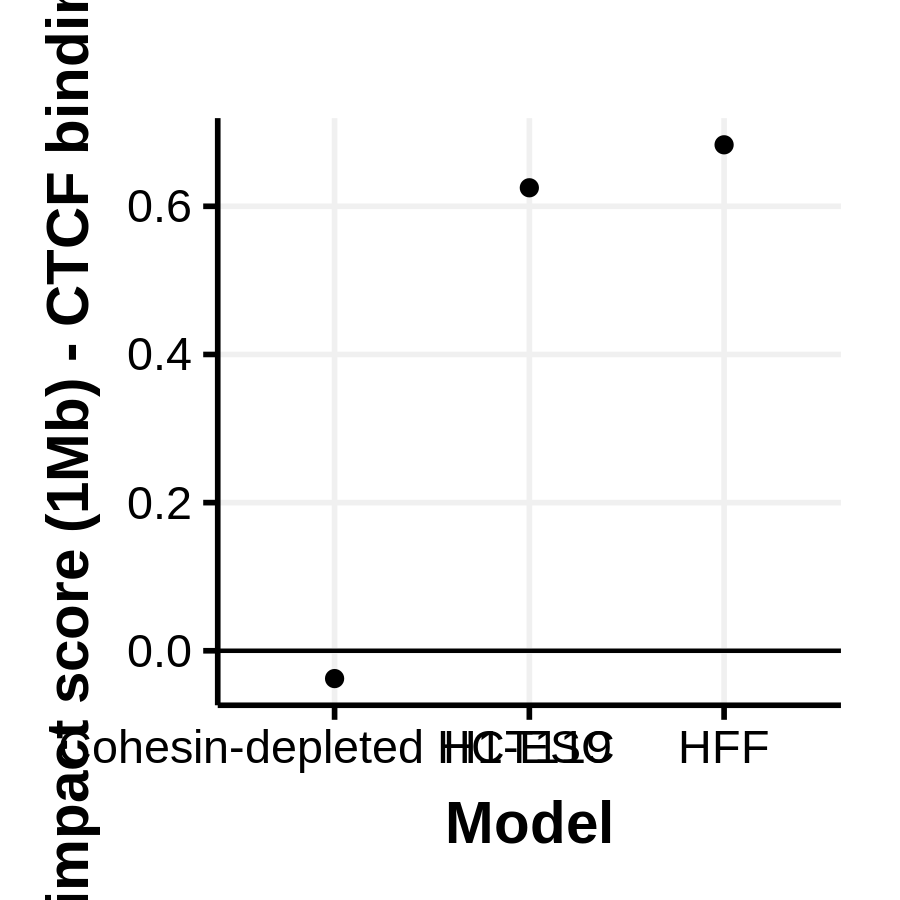

In [56]:
%%R -i plotdata -w 3 -h 3 --units in -r 300
#No apparent CTCF dependency is observed for cohesin-deplted HCT119 model

theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
require(ggplot2)
p=ggplot(plotdata)+geom_point(aes(x=Model,y=Cor),stat='identity')+
    theme_Publication()+geom_hline(yintercept=0)+ylab('Structural impact score (1Mb) - CTCF binding correlation')
ggsave('./figures/local_interaction.ctcfchipcor.hctnoc.pdf', device=cairo_pdf)
p